In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import dask.dataframe as dd
from geopy.distance import geodesic
import string
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, skew

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
dir = '../csv/'
fname = 'sample_300k_2020'

*** Went many times from EDA back & forth to preparation, added/removed features... for ease of use I added & packed them all into a pickle file in the preparation stage.

In [3]:
df_BASE = pd.read_pickle(fname + '_prepared.pkl')

In [ ]:
#df_eda.to_csv('credit_card_fraud_sample_2019_Dec_100K_prepared.csv')

In [4]:
print('df_eda shape: ' + str(df_BASE.shape))
print(df_BASE.info())

df_eda shape: (299996, 41)
<class 'pandas.core.frame.DataFrame'>
Index: 299996 entries, 70705 to 127819
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     299996 non-null  int64         
 1   ssn                    299996 non-null  object        
 2   cc_num                 299996 non-null  int64         
 3   first                  299996 non-null  object        
 4   last                   299996 non-null  object        
 5   gender                 299996 non-null  object        
 6   street                 299996 non-null  object        
 7   city                   299996 non-null  object        
 8   state                  299996 non-null  object        
 9   zip                    299996 non-null  int32         
 10  lat                    299996 non-null  float64       
 11  long                   299996 non-null  float64       
 12  city_pop          

In [5]:
df_BASE.head()

id          ssn            cc_num     first      last gender  \
70705  8122311  422-91-6327  3510694985435665  samantha  gonzalez      f   
69722  8123218  422-91-6327  3510694985435665  samantha  gonzalez      f   
69411  8122430  422-91-6327  3510694985435665  samantha  gonzalez      f   
70857  8124392  422-91-6327  3510694985435665  samantha  gonzalez      f   
69729  8123640  422-91-6327  3510694985435665  samantha  gonzalez      f   

                               street    city state    zip  ...  is_weekend  \
70705  16112_stanley_springs_apt._132  sidney    NE  69162  ...           0   
69722  16112_stanley_springs_apt._132  sidney    NE  69162  ...           0   
69411  16112_stanley_springs_apt._132  sidney    NE  69162  ...           1   
70857  16112_stanley_springs_apt._132  sidney    NE  69162  ...           0   
69729  16112_stanley_springs_apt._132  sidney    NE  69162  ...           0   

       trans_hour  trans_time_segment age age_group  cc_type area_cat  \
70705          22       evening_18-24  79    senior  Unknown    urban   
69722           3      late_night_0-6  79    senior  Unknown    urban   
69411           2      late_night_0-6  79    senior  Unknown    urban   
70857          16     afternoon_12-18  79    senior  Unknown    urban   
69729          19       evening_18-24  79    senior  Unknown    urban   

         distance time_since_last_trans     job_cat  
70705   92.807059              0.000000  Management  
69722  111.944237             76.854444  Management  
69411   98.159778           1198.525278  Management  
70857   41.599238            638.237778  Management  
69729   83.879382            170.932222  Management  

[5 rows x 41 columns]

***drop irrelevant features***

In [6]:
#'Datetime','Month' wetre added in the previous step temporarily for to analyse a distribution, we'll use trans_date and treans_time for the analysis
df_BASE = df_BASE.drop(['Datetime','Month'], axis=1)
df_eda = df_BASE.copy()
df_eda = df_eda.drop(['ssn', 'id', 'first', 'last', 'street'], axis=1)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299996 entries, 70705 to 127819
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   cc_num                 299996 non-null  int64         
 1   gender                 299996 non-null  object        
 2   city                   299996 non-null  object        
 3   state                  299996 non-null  object        
 4   zip                    299996 non-null  int32         
 5   lat                    299996 non-null  float64       
 6   long                   299996 non-null  float64       
 7   city_pop               299996 non-null  int64         
 8   job                    299996 non-null  object        
 9   dob                    299996 non-null  datetime64[ns]
 10  acct_num               299996 non-null  int64         
 11  profile                299996 non-null  object        
 12  trans_num              299996 non-null  objec

**Data Protocol**

In [7]:
#Type of data 
df_eda.dtypes.to_excel ("df_datatype.xlsx", sheet_name='data_types')

#Maximum points 
df_eda.max().to_excel("df_max.xlsx", sheet_name='max')

#Minimum points 
df_eda.min().to_excel("df_min.xlsx", sheet_name='min')
        
#Isnull values 
df_eda.isnull().to_excel("df_isnull.xlsx", sheet_name='isnull')

#unique values 
df_eda.nunique().to_excel("df_nunique.xlsx", sheet_name='nunique')

*helper Functions*

In [8]:
def plot_categorical(df_in, col, target='is_fraud', top_n=10):
    """
    Plot a bar chart of the counts of the top_n categories in a column.
    """
    # Get the top_n categories
    top_n_cats = df_in[col].value_counts().head(top_n).index
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_in, y=col, order=top_n_cats, hue=target)
    plt.title(f'Count of {col} with Fraud')
    plt.show()

def plot_numerical(df_in, col, target='is_fraud', bins=30):
    """
    Plot a histogram of a numerical column.
    """
    # Create a histogram    
    plt.figure(figsize=(10, 6))
    sns.histplot(df_in, x=col, bins=bins, hue=target, kde=True)
    plt.title(f'{col} Distribution with Fraud')
    plt.show()

def plot_categorical_percent(df_in, col, target='is_fraud', top_n=10):
    """
    Plot a bar chart of the percentage of the top_n categories in a column.
    """
    # Get the top_n categories  
    top_n_cats = df_in[col].value_counts().head(top_n).index
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    (df_in[col].value_counts() / len(df_in)).head(top_n).plot(kind='bar')
    plt.title(f'Percentage of {col}')
    plt.show()

def plot_numerical_percent(df_in, col, target='is_fraud', bins=30):
    """
    Plot a histogram of a numerical column.
    """
    # Create a histogram
    plt.figure(figsize=(10, 6))
    df_in[col].plot(kind='hist', bins=bins)

    plt.title(f'{col} Distribution')
    plt.show()



***Descriptive EDA***

**Preliminary focus on:**
-   Categorical features:
-   Numeric features:
-   Unique identifiers:


In [9]:
df_eda.describe()

cc_num            zip            lat           long  \
count  2.999960e+05  299996.000000  299996.000000  299996.000000   
mean   3.717795e+17   51171.855838      37.571051     -91.975277   
min    6.040003e+10    1002.000000      19.589300    -163.118900   
25%    3.851192e+13   27607.000000      33.892500     -98.574675   
50%    3.506154e+15   48135.000000      38.561700     -87.155400   
75%    4.589685e+15   78250.000000      41.240500     -79.987000   
max    4.999689e+18   99929.000000      66.693300     -67.407300   
std    1.237935e+18   29682.908465       5.183478      16.478501   

           city_pop                            dob      acct_num  \
count  2.999960e+05                         299996  2.999960e+05   
mean   2.963910e+05  1978-10-26 15:28:08.134508512  4.979541e+11   
min    4.400000e+01            1928-01-05 00:00:00  1.837412e+07   
25%    1.771500e+04            1967-07-20 00:00:00  2.469957e+11   
50%    6.079700e+04            1981-07-05 00:00:00  4.975043e+11   
75%    2.368230e+05            1992-12-13 00:00:00  7.507955e+11   
max    2.906700e+06            2008-11-24 00:00:00  9.999583e+11   
std    5.705556e+05                            NaN  2.893002e+11   

                          trans_date                     trans_time  \
count                         299996                         299996   
mean   2020-07-20 12:21:51.569486848  1900-01-01 17:16:10.421028608   
min              2020-01-01 00:00:00            1900-01-01 00:00:02   
25%              2020-04-26 00:00:00  1900-01-01 14:25:48.750000128   
50%              2020-07-23 00:00:00            1900-01-01 17:37:42   
75%              2020-10-22 00:00:00  1900-01-01 20:50:01.249999872   
max              2020-12-31 00:00:00            1900-01-01 23:59:59   
std                              NaN                            NaN   

          unix_time            amt       is_fraud      merch_lat  \
count  2.999960e+05  299996.000000  299996.000000  299996.000000   
mean   1.595290e+09      66.666112       0.005247      37.569849   
min    1.577817e+09       1.000000       0.000000      18.614906   
25%    1.587903e+09       8.230000       0.000000      33.859342   
50%    1.595500e+09      33.150000       0.000000      38.435078   
75%    1.603359e+09      76.392500       0.000000      41.311298   
max    1.609439e+09   24006.930000       1.000000      67.637845   
std    9.051101e+06     204.176166       0.072244       5.215612   

          merch_long  trans_day_of_week     is_weekend     trans_hour  \
count  299996.000000      299996.000000  299996.000000  299996.000000   
mean      -91.974516           3.555834       0.398735      16.768957   
min      -163.841588           0.000000       0.000000       0.000000   
25%       -98.837592           2.000000       0.000000      14.000000   
50%       -87.029545           4.000000       0.000000      17.000000   
75%       -79.732730           5.000000       1.000000      20.000000   
max       -66.409911           6.000000       1.000000      23.000000   
std        16.489041           1.949197       0.489639       4.532406   

                 age       distance  time_since_last_trans  
count  299996.000000  299996.000000          299996.000000  
mean       41.680929      76.509002             427.354072  
min        12.000000       0.061514               0.000000  
25%        28.000000      55.620571              77.872153  
50%        39.000000      78.718629             239.562222  
75%        53.000000      98.924832             551.475208  
max        92.000000     148.455852            7923.052500  
std        17.892554      29.203572             560.720134

In [10]:
df_eda['is_fraud'].value_counts()

is_fraud
0    298422
1      1574
Name: count, dtype: int64

In [11]:
df_eda.columns

Index(['cc_num', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'acct_num', 'profile', 'trans_num', 'trans_date',
       'trans_time', 'unix_time', 'category', 'amt', 'is_fraud', 'merchant',
       'merch_lat', 'merch_long', 'region', 'trans_day_of_week', 'is_weekend',
       'trans_hour', 'trans_time_segment', 'age', 'age_group', 'cc_type',
       'area_cat', 'distance', 'time_since_last_trans', 'job_cat'],
      dtype='object')

In [12]:
cols_of_interest = ['gender', 'city_pop', 'job', 'dob', 'acct_num', 'trans_date', 'trans_time', 'unix_time', 'category', 
       'amt', 'is_fraud', 'region', 'trans_day_of_week', 'is_weekend', 'trans_hour','trans_time_segment', 
       'age', 'age_group', 'cc_type', 'area_cat', 'distance', 'time_since_last_trans', 'job_cat']

In [31]:
from autoviz.AutoViz_Class import AutoViz_Class
%matplotlib inline

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [32]:
#

df_eda_subset = df_eda[cols_of_interest]
#df_subset.to_csv(fname + '_subset.csv', index=False)
df_eda_subset.head()

gender  city_pop       job          dob      acct_num trans_date  \
70705    f      7765    energy_manager 1941-05-26  18374117 2020-02-10   
69722    f      7765    energy_manager 1941-05-26  18374117 2020-02-14   
69411    f      7765    energy_manager 1941-05-26  18374117 2020-04-04   
70857    f      7765    energy_manager 1941-05-26  18374117 2020-04-30   
69729    f      7765    energy_manager 1941-05-26  18374117 2020-05-07   

           trans_time       unix_time     category      amt   is_fraud  \
70705 1900-01-01 22:53:18  1581355398     grocery_pos   8.40      1      
69722 1900-01-01 03:44:34  1581632074   entertainment   5.10      0      
69411 1900-01-01 02:16:05  1585946765     food_dining  93.69      0      
70857 1900-01-01 16:30:21  1588244421  health_fitness  78.05      0      
69729 1900-01-01 19:26:17  1588859777  health_fitness  12.46      0      

       region   trans_day_of_week  is_weekend  trans_hour trans_time_segment  \
70705  Midwest          0               0          22         evening_18-24    
69722  Midwest          4               0           3        late_night_0-6    
69411  Midwest          5               1           2        late_night_0-6    
70857  Midwest          3               0          16       afternoon_12-18    
69729  Midwest          3               0          19         evening_18-24    

       age age_group cc_type  area_cat   distance   time_since_last_trans  \
70705  79    senior   Unknown   urban    92.807059          0.000000        
69722  79    senior   Unknown   urban   111.944237         76.854444        
69411  79    senior   Unknown   urban    98.159778       1198.525278        
70857  79    senior   Unknown   urban    41.599238        638.237778        
69729  79    senior   Unknown   urban    83.879382        170.932222        

        job_cat    
70705  Management  
69722  Management  
69411  Management  
70857  Management  
69729  Management

    Since nrows is smaller than dataset, loading random sample of 150000 rows into pandas...
Shape of your Data Set loaded: (150000, 23)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    22 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
Since Number of Rows in data 150000 exceeds maximum, randomly sampling 150000 rows for EDA...

################ Binary_Classification problem #####################
    All variables classified into correct types.


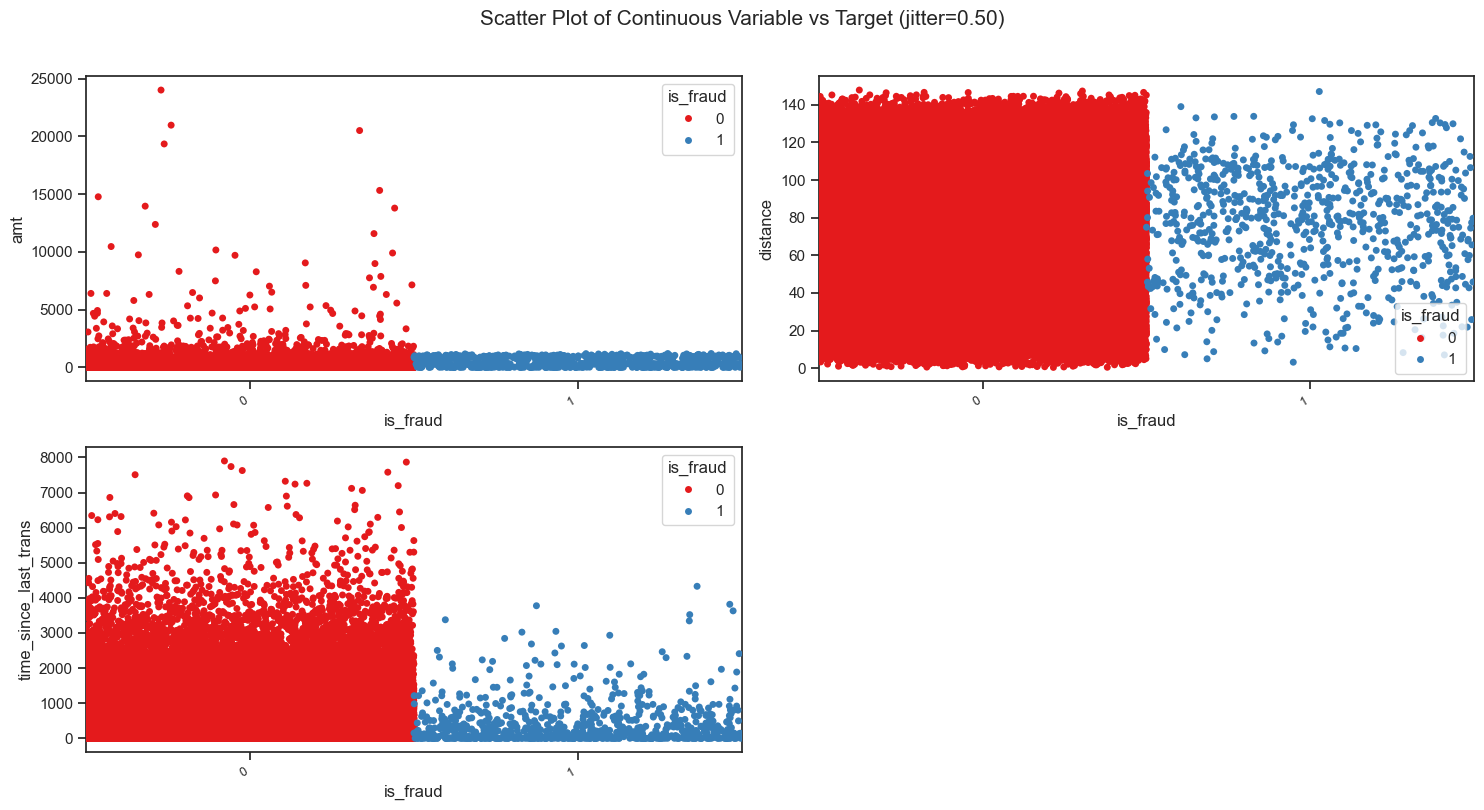

Total Number of Scatter Plots = 6


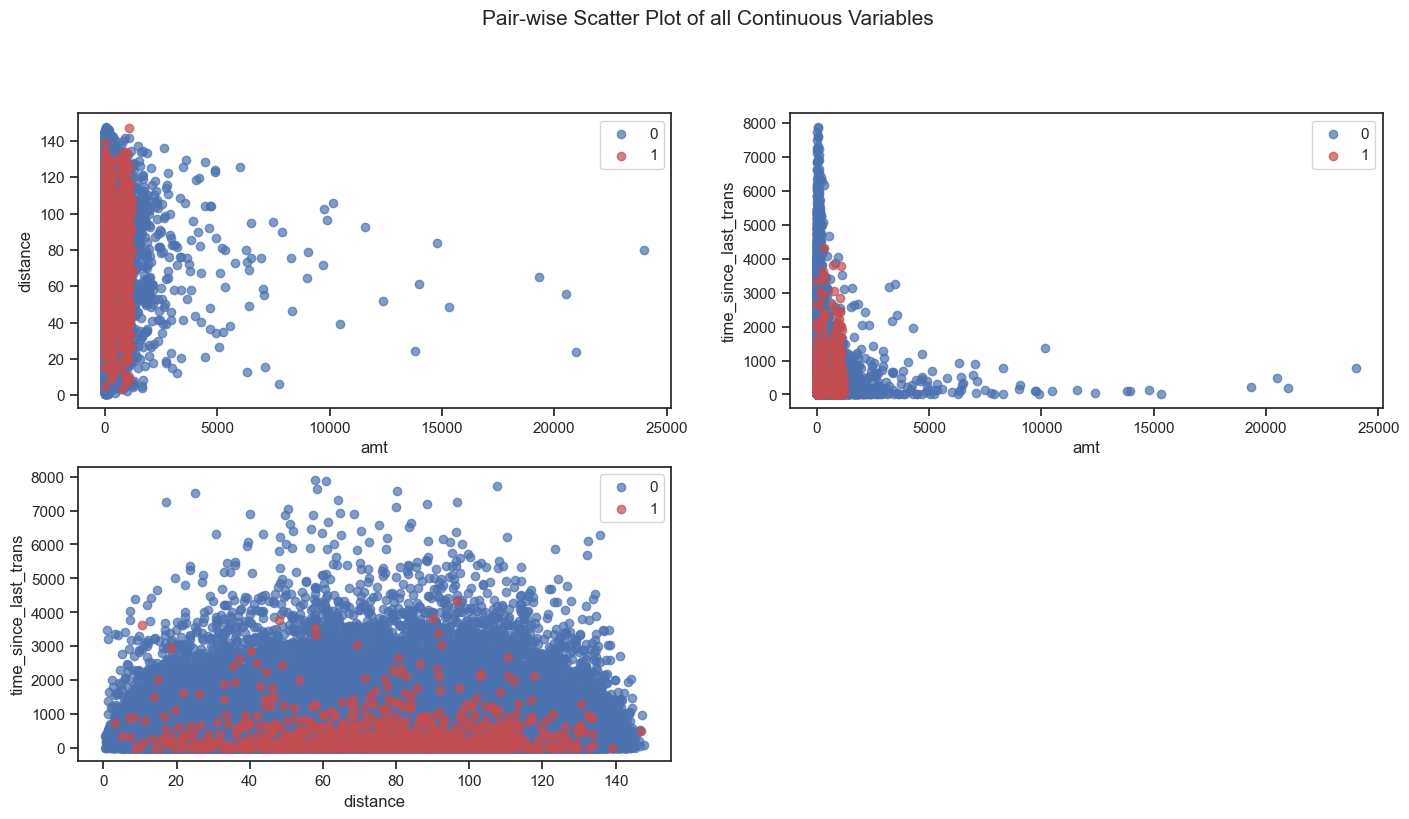

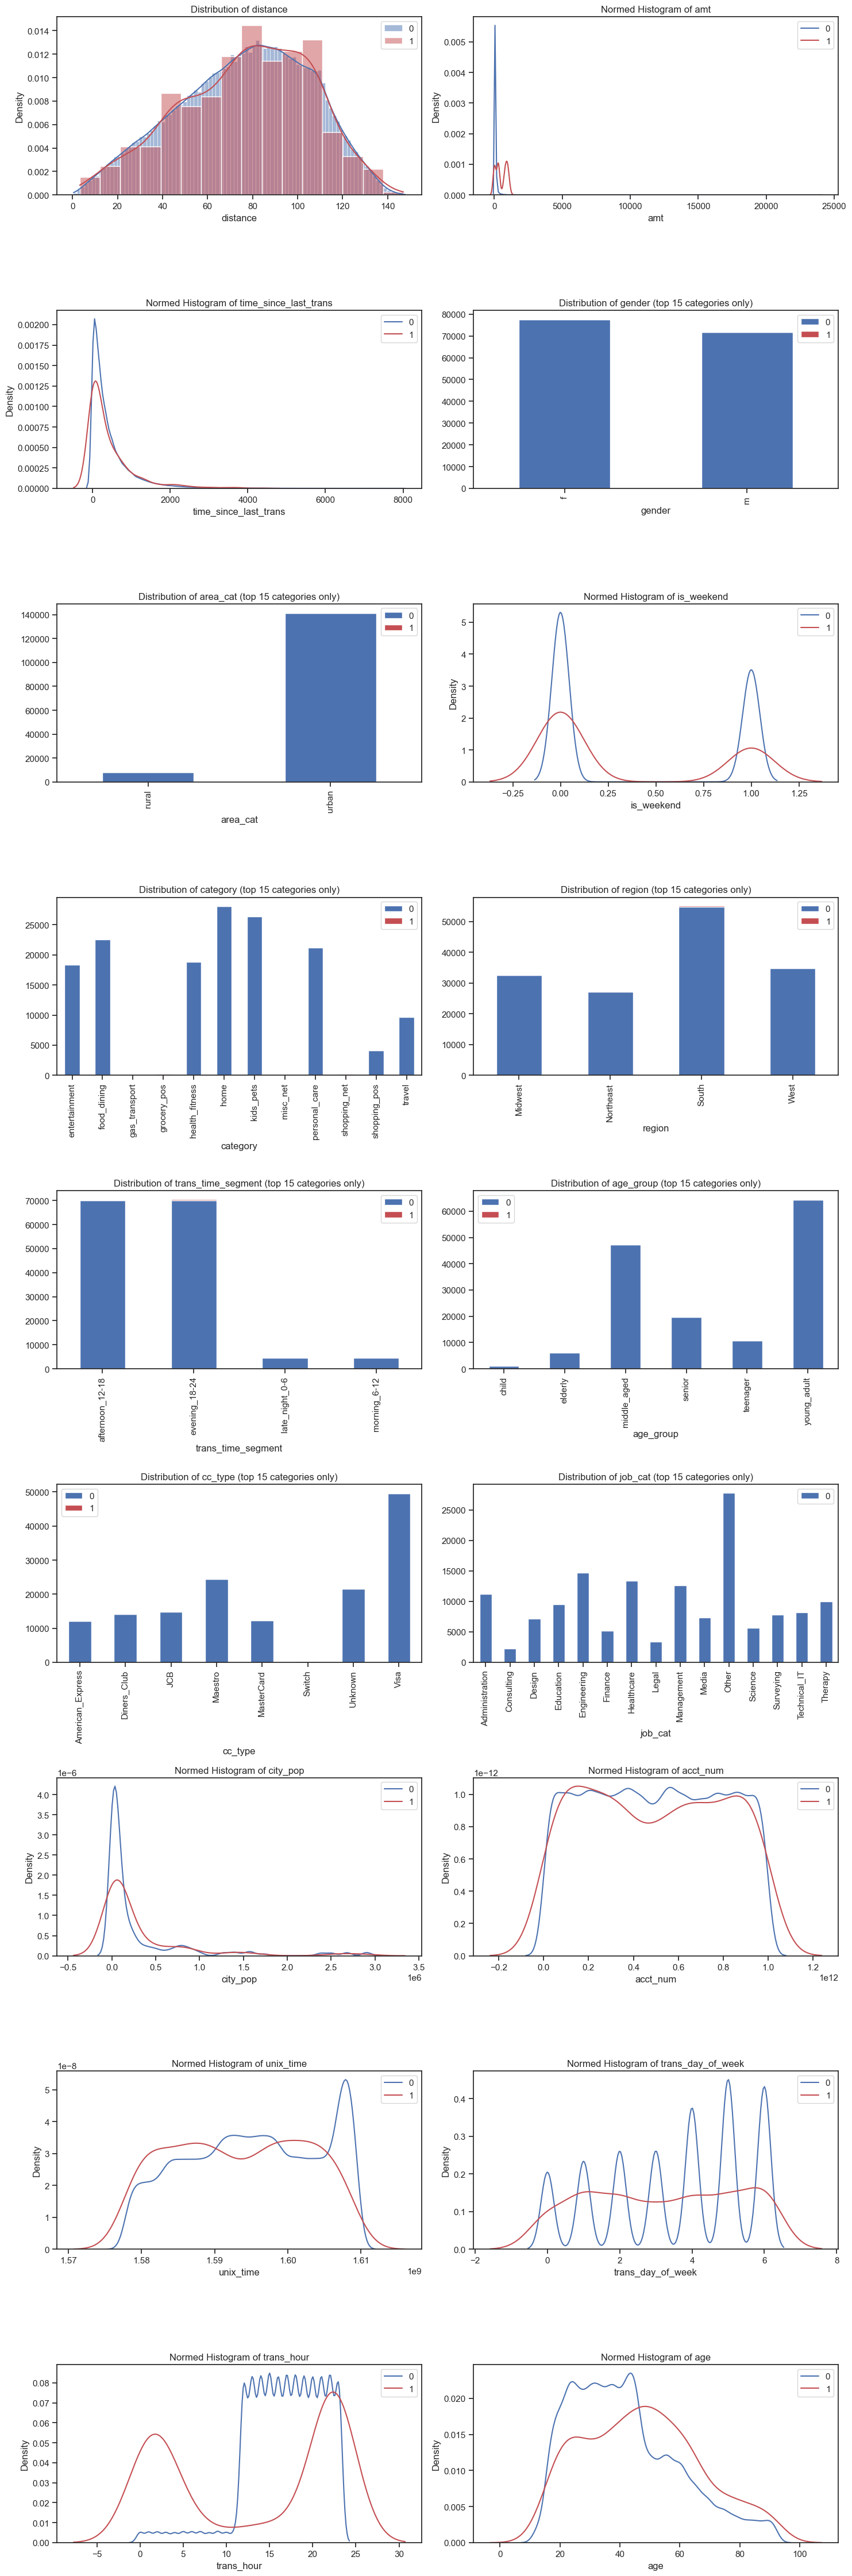

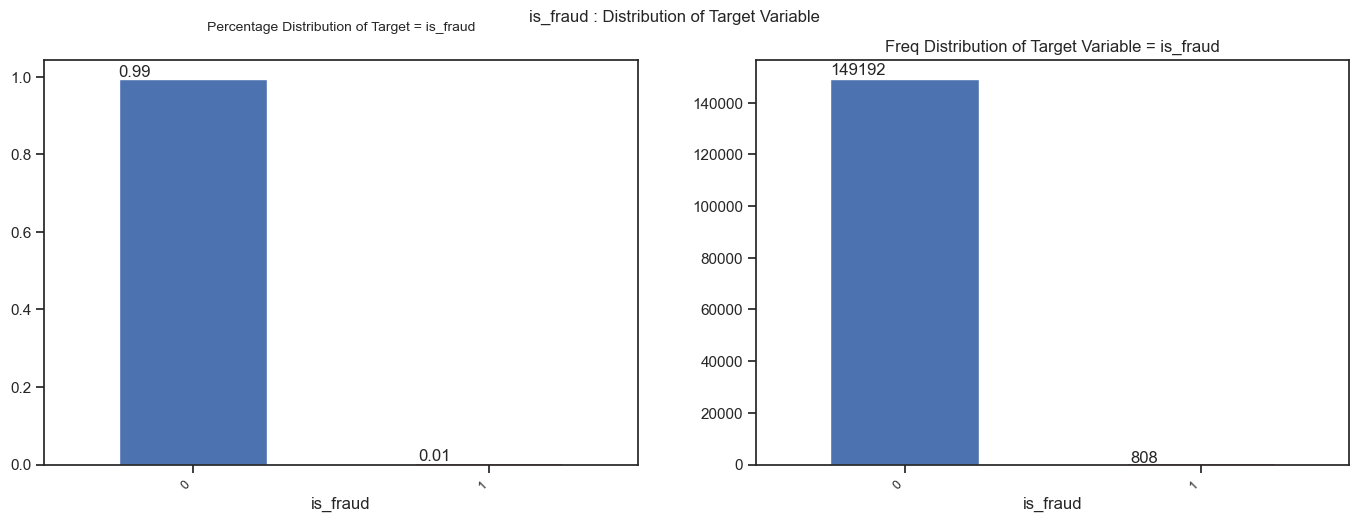

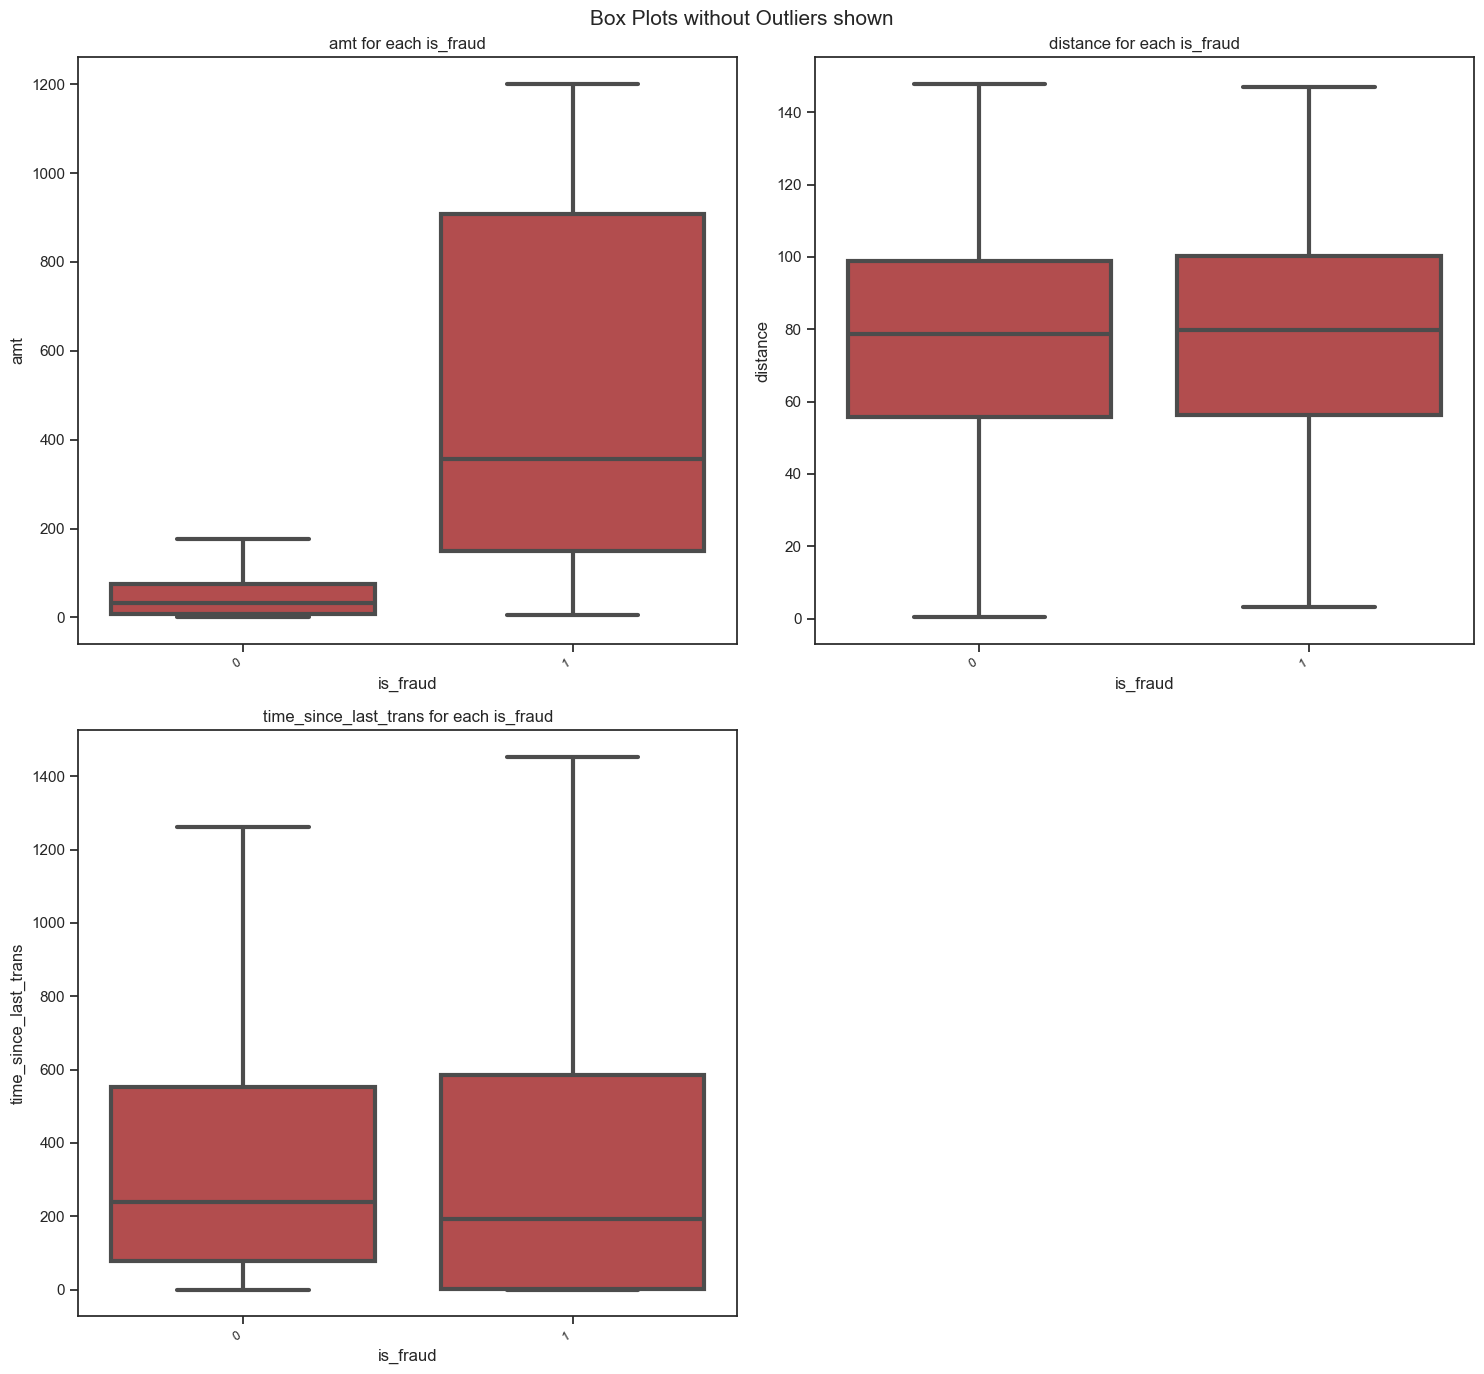

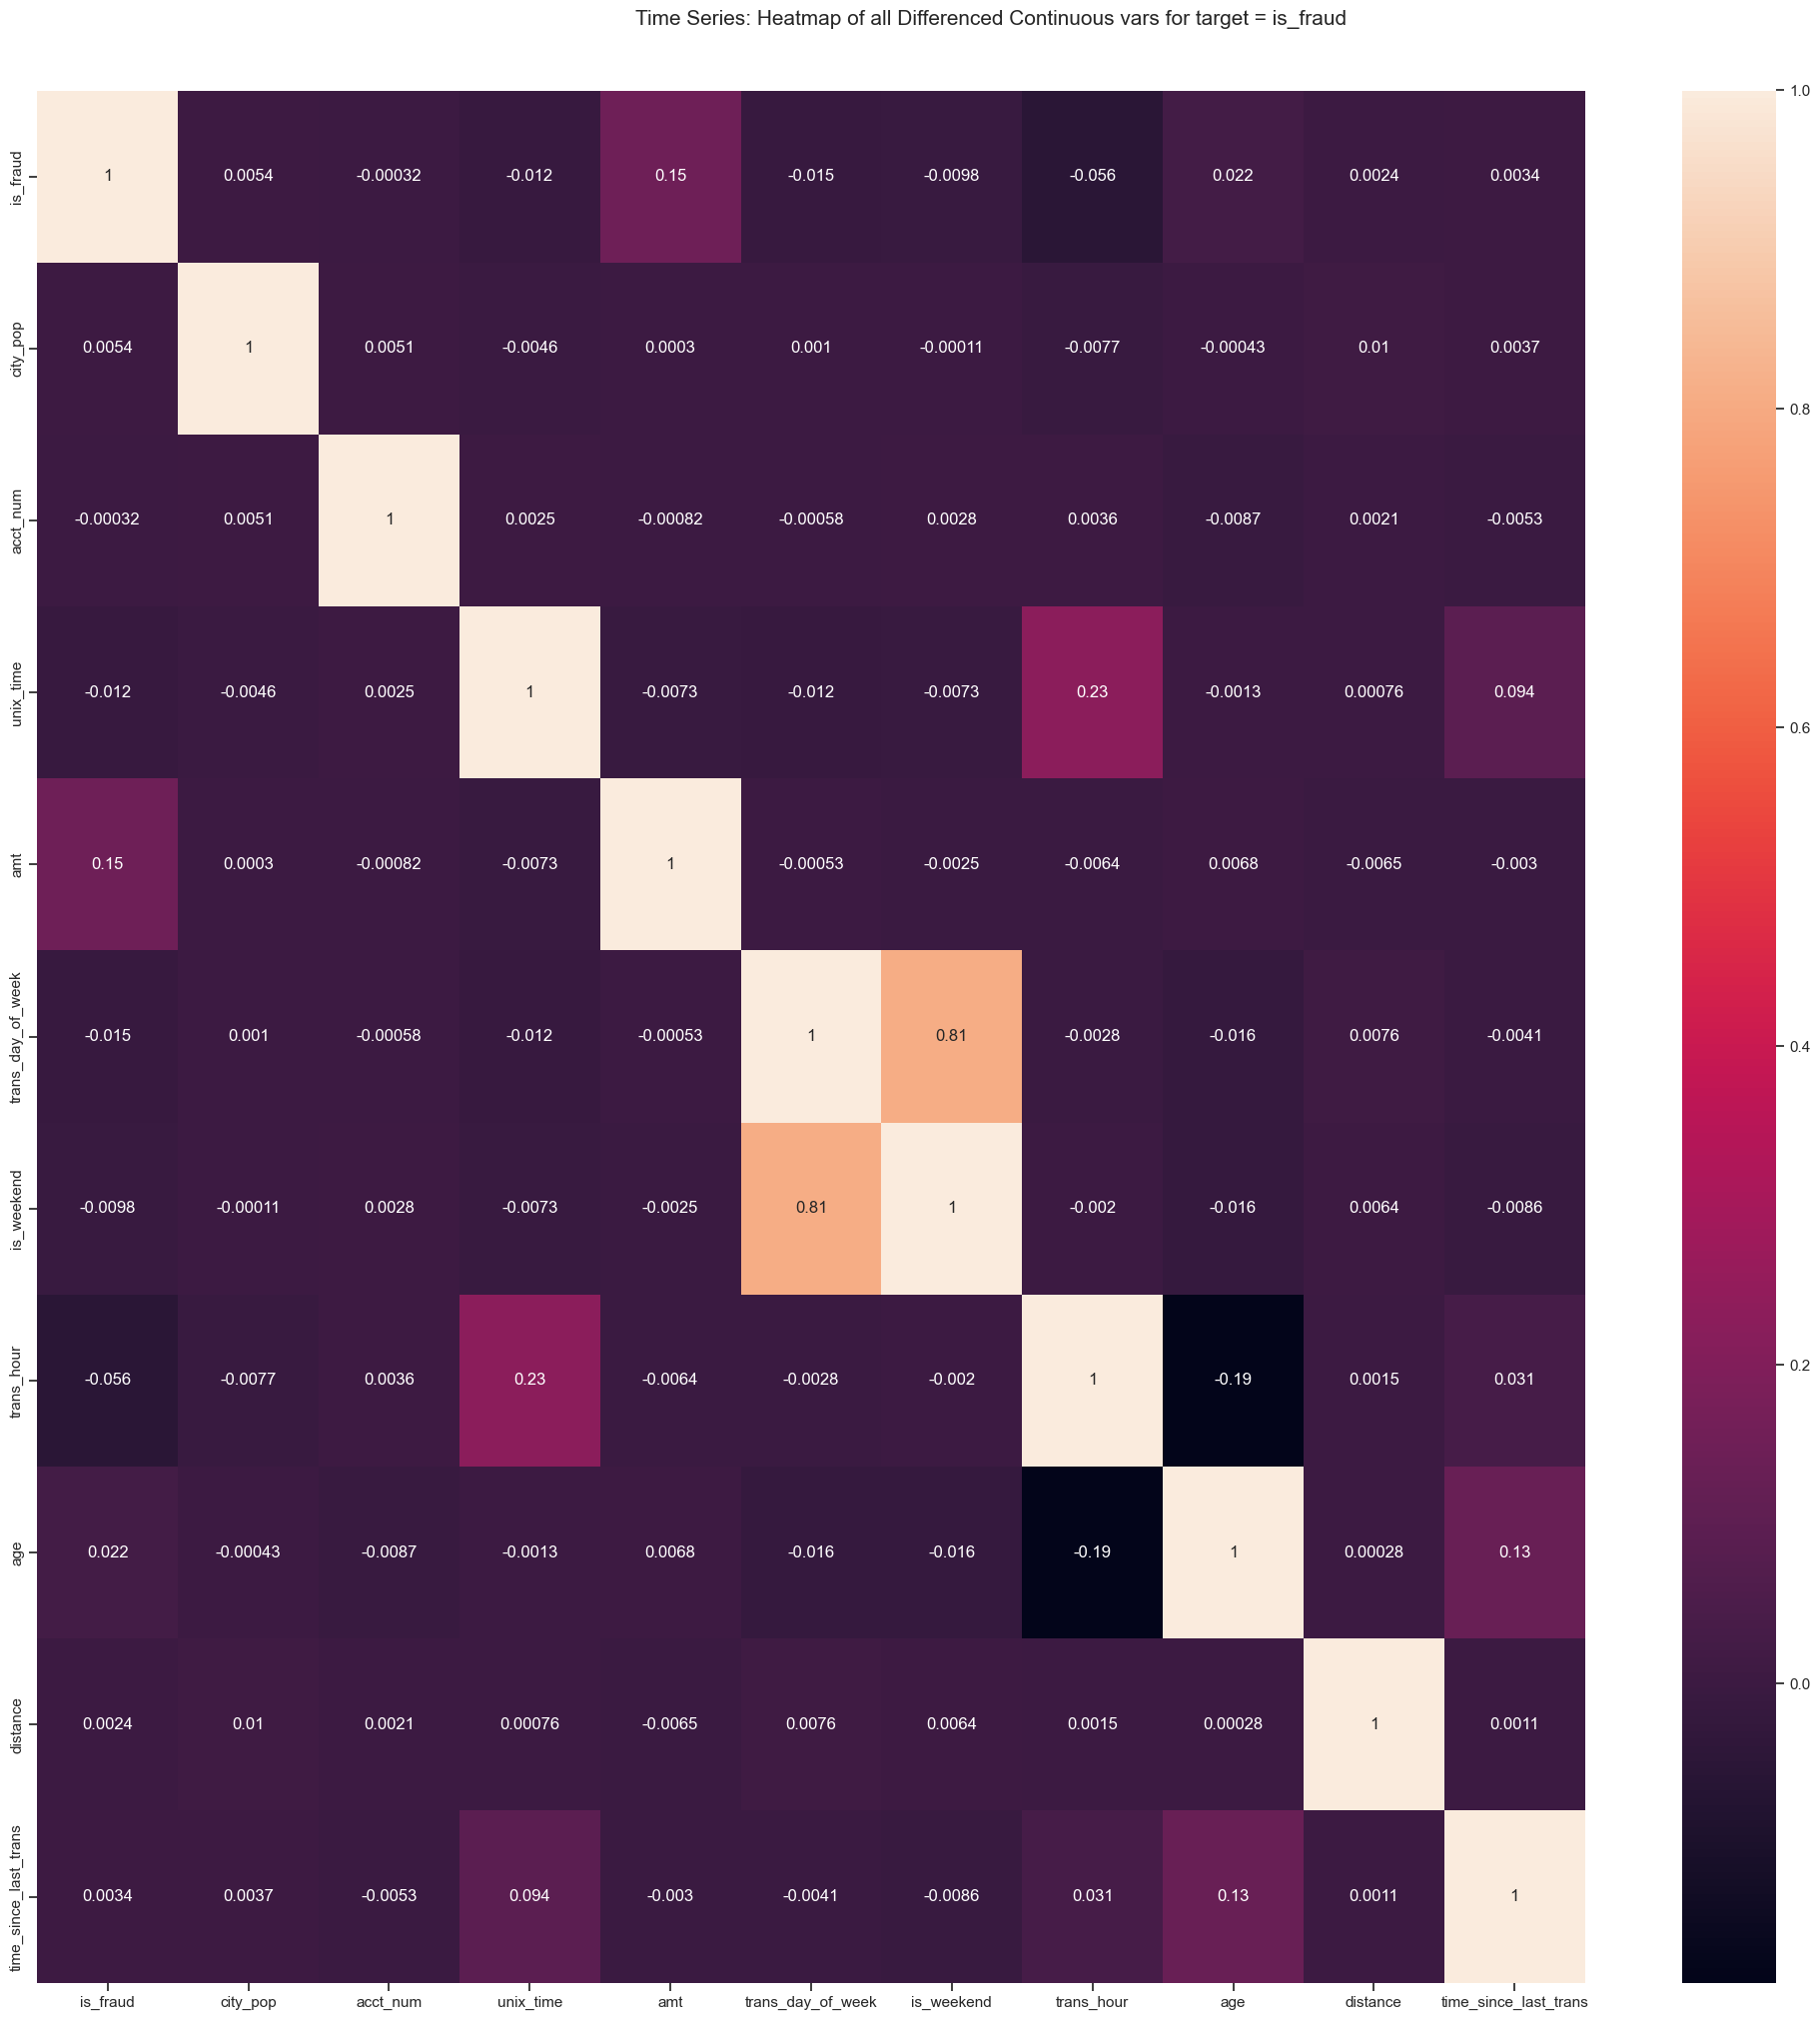

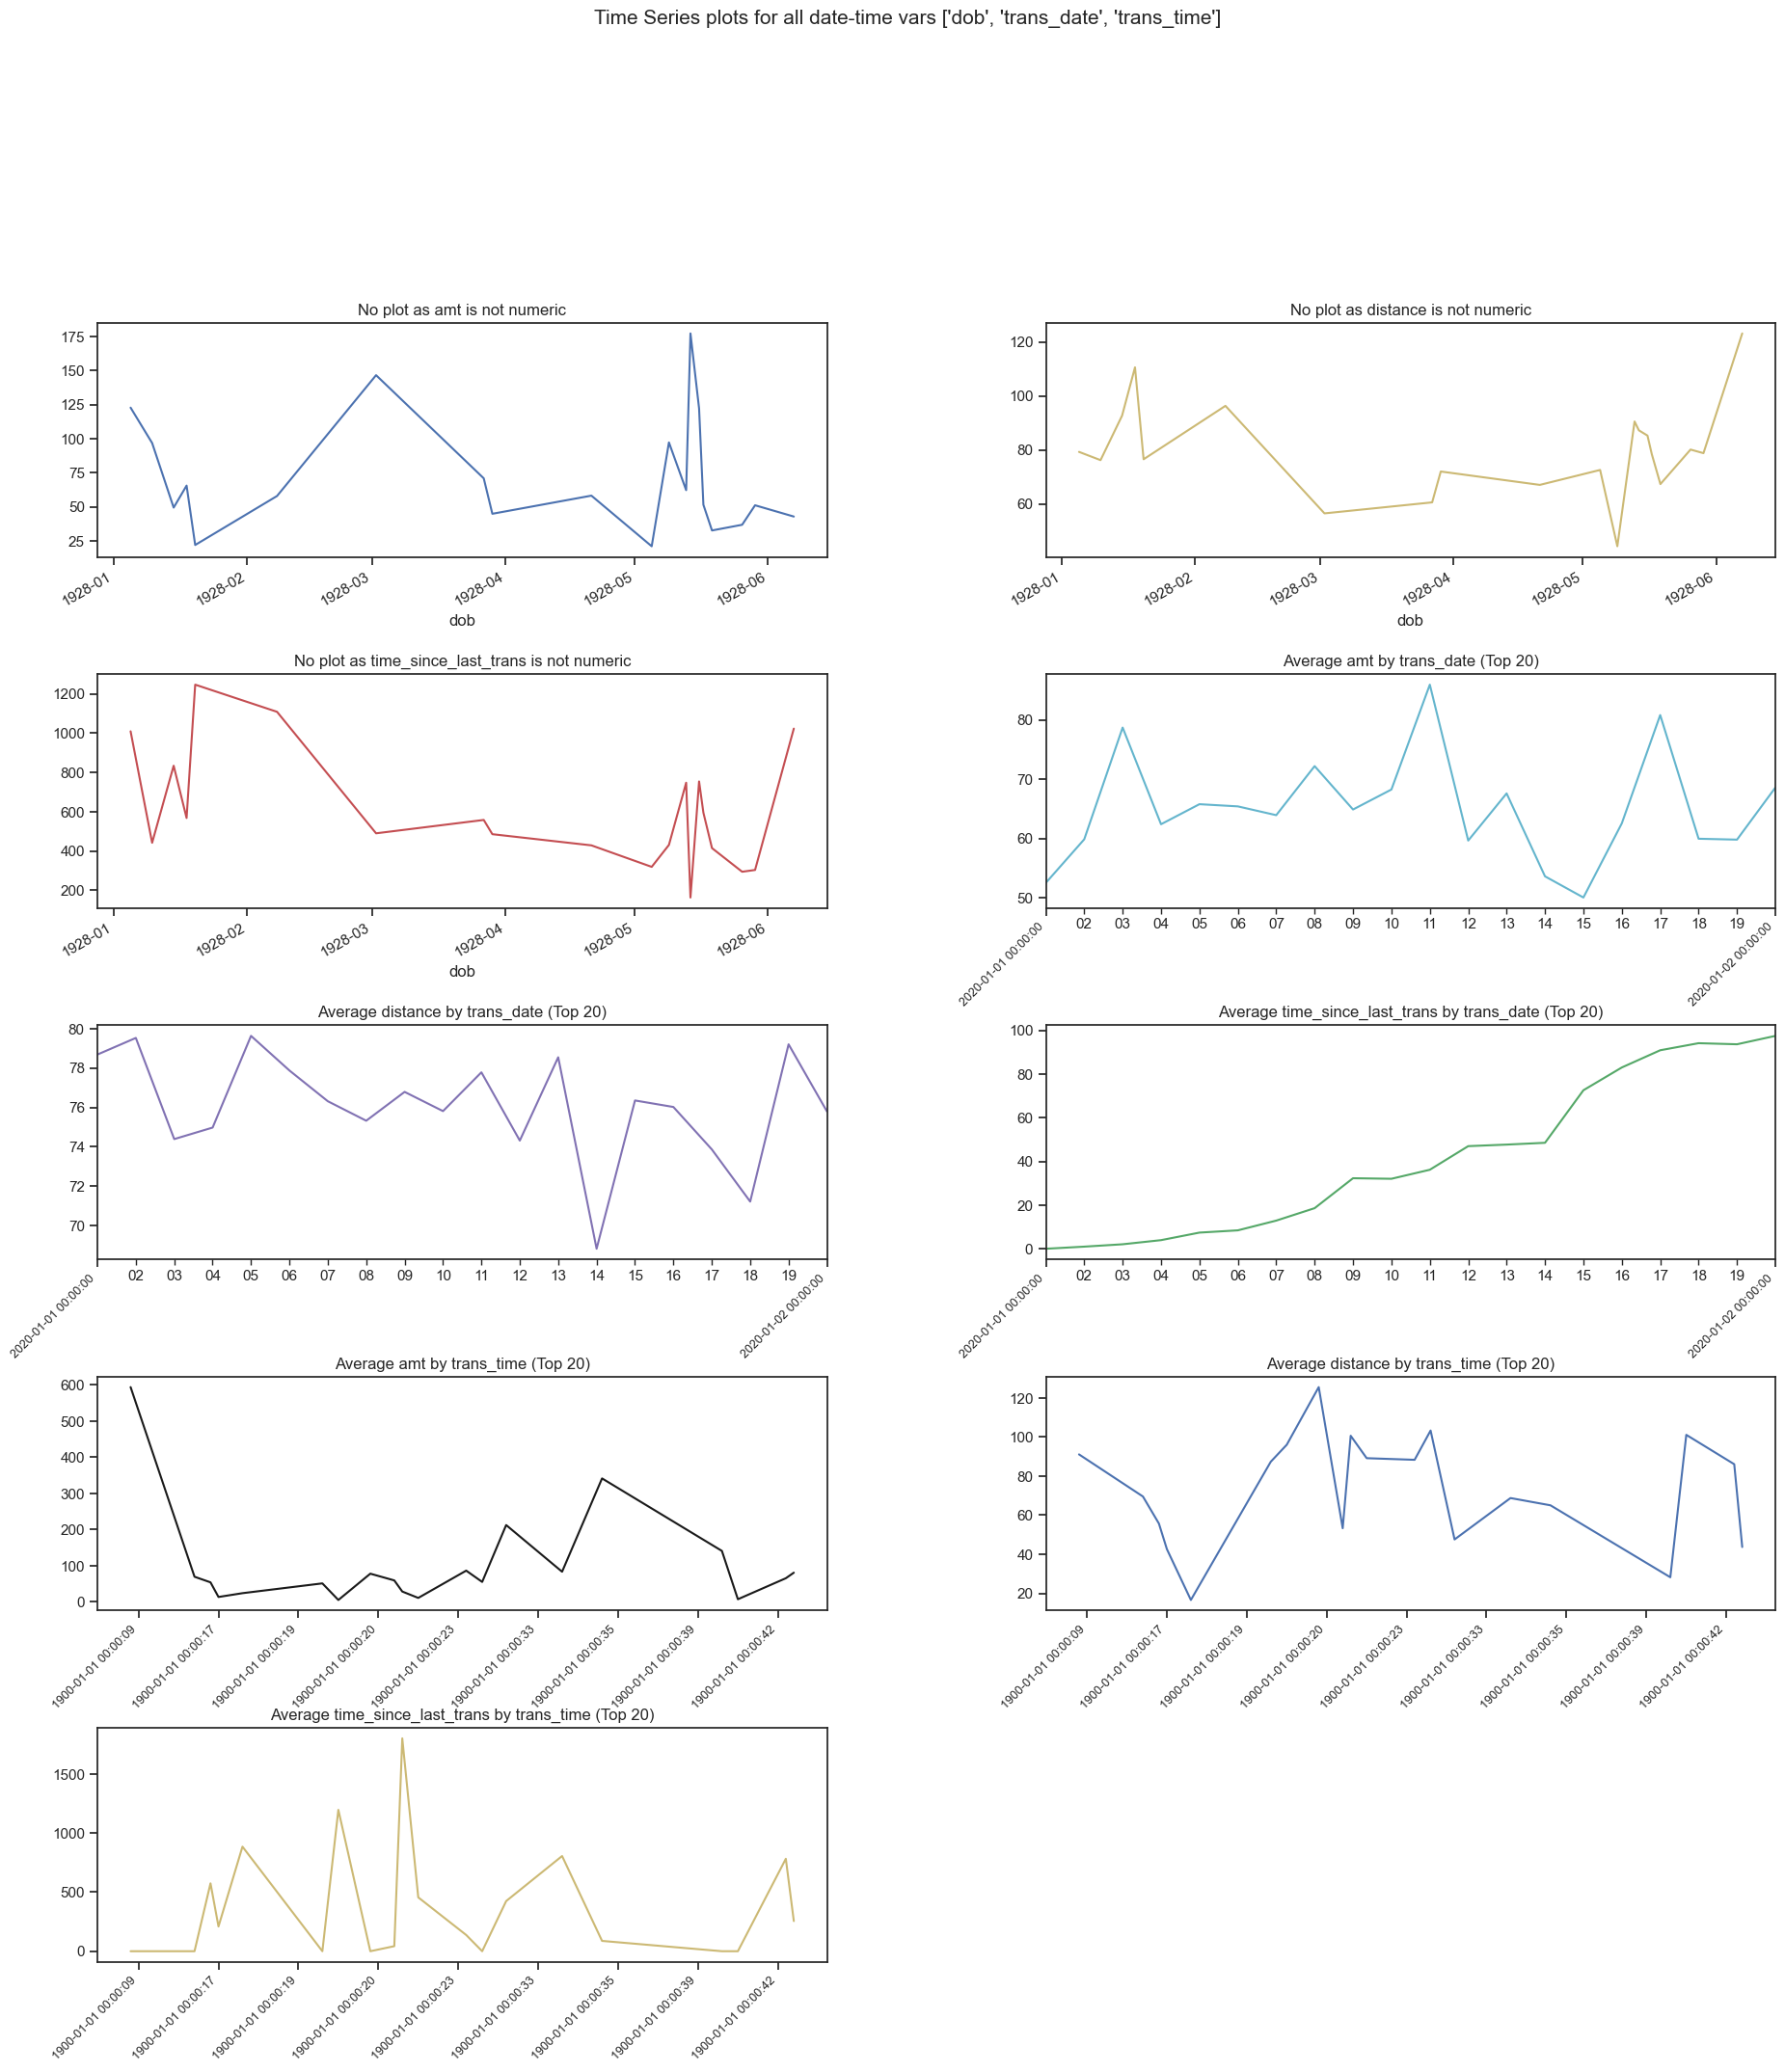

Could not draw some Time Series plots. 'NoneType' object has no attribute 'suptitle'


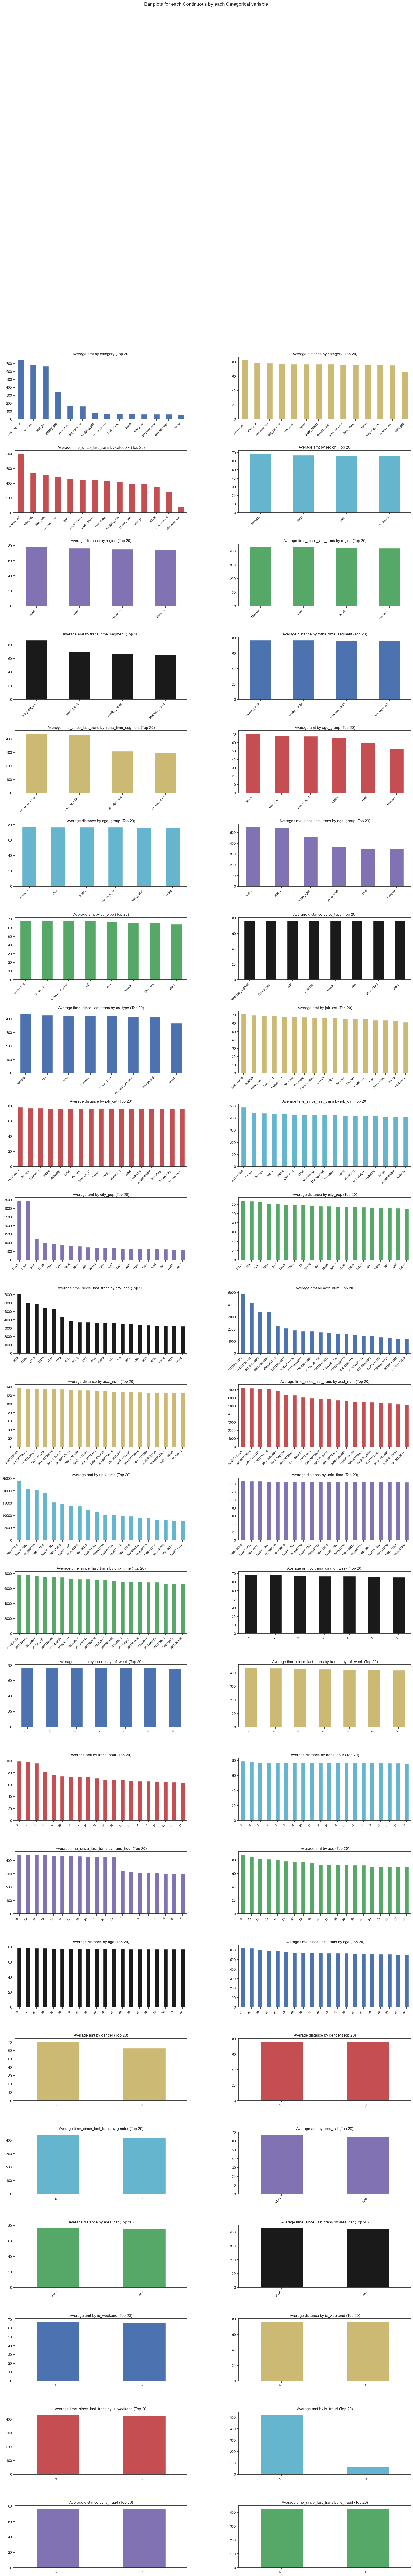

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\DCervin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\DCervin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\DCervin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\DCervin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\DCervin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nlt

Could not draw wordcloud plot for job. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

All Plots done
Time to run AutoViz = 26 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


gender  city_pop                  job                      dob      \
264227    m      236823             sports_development_officer 1994-07-18   
244616    m     2504700                                    sub 1994-06-05   
204924    f       14970       higher_education_careers_adviser 1982-01-12   
60178     f      238602         commercial_art_gallery_manager 1960-05-29   
27764     m      847415               customer_service_manager 1988-09-20   
...       ...       ...                                    ...        ...   
188496    m      525713     research_scientist_(life_sciences) 1996-03-02   
178797    f      673342                                 dancer 1960-02-18   
189298    m        6040  product/process_development_scientist 1979-01-01   
226646    f        5631                  volunteer_coordinator 1967-05-21   
189384    m        5409                          stage_manager 1988-10-07   

          acct_num   trans_date      trans_time       unix_time  \
264227  397946208876 2020-04-30 1900-01-01 23:24:42  1588269282   
244616  879977380114 2020-05-03 1900-01-01 12:15:30  1588488330   
204924  252554464624 2020-06-20 1900-01-01 16:02:33  1592649153   
60178   166427574276 2020-05-22 1900-01-01 18:33:13  1590152593   
27764   520398932410 2020-05-16 1900-01-01 22:38:12  1589648892   
...              ...        ...                 ...         ...   
188496  191480777306 2020-05-12 1900-01-01 23:34:43  1589306683   
178797  807974091405 2020-12-20 1900-01-01 22:32:26  1608483746   
189298  997917536399 2020-07-08 1900-01-01 16:18:08  1594205288   
226646  792138186400 2020-06-23 1900-01-01 19:35:52  1592921152   
189384   15483531111 2020-08-21 1900-01-01 23:28:15  1598032695   

           category       amt    region    trans_day_of_week  is_weekend  \
264227     food_dining    4.48      South          3               0       
244616     food_dining    6.39  Northeast          6               1       
204924  health_fitness   88.70    Midwest          5               1       
60178   health_fitness   63.50      South          4               0       
27764      food_dining   75.50      South          5               1       
...                ...     ...        ...                ...         ...   
188496     food_dining   63.51       West          1               0       
178797          travel  119.57    Midwest          6               1       
189298  health_fitness   19.72  Northeast          2               0       
226646            home   53.66  Northeast          1               0       
189384            home   18.26      South          4               0       

        trans_hour trans_time_segment  age  age_group        cc_type       \
264227      23         evening_18-24   26   young_adult              Visa   
244616      12       afternoon_12-18   26   young_adult              Visa   
204924      16       afternoon_12-18   38   young_adult              Visa   
60178       18         evening_18-24   60        senior  American_Express   
27764       22         evening_18-24   32   young_adult              Visa   
...            ...                ...  ...          ...               ...   
188496      23         evening_18-24   24   young_adult           Maestro   
178797      22         evening_18-24   60        senior              Visa   
189298      16       afternoon_12-18   41   middle_aged           Unknown   
226646      19         evening_18-24   53   middle_aged              Visa   
189384      23         evening_18-24   32   young_adult        MasterCard   

       area_cat   distance   time_since_last_trans     job_cat      is_fraud  
264227   urban   109.832479         11.063889            Surveying      0     
244616   urban    13.994072        492.378611                Other      0     
204924   urban    90.707355          1.461389            Education      0     
60178    urban    88.835580        450.793056              Therapy      0     
27764    urban    70.293101          6.11944

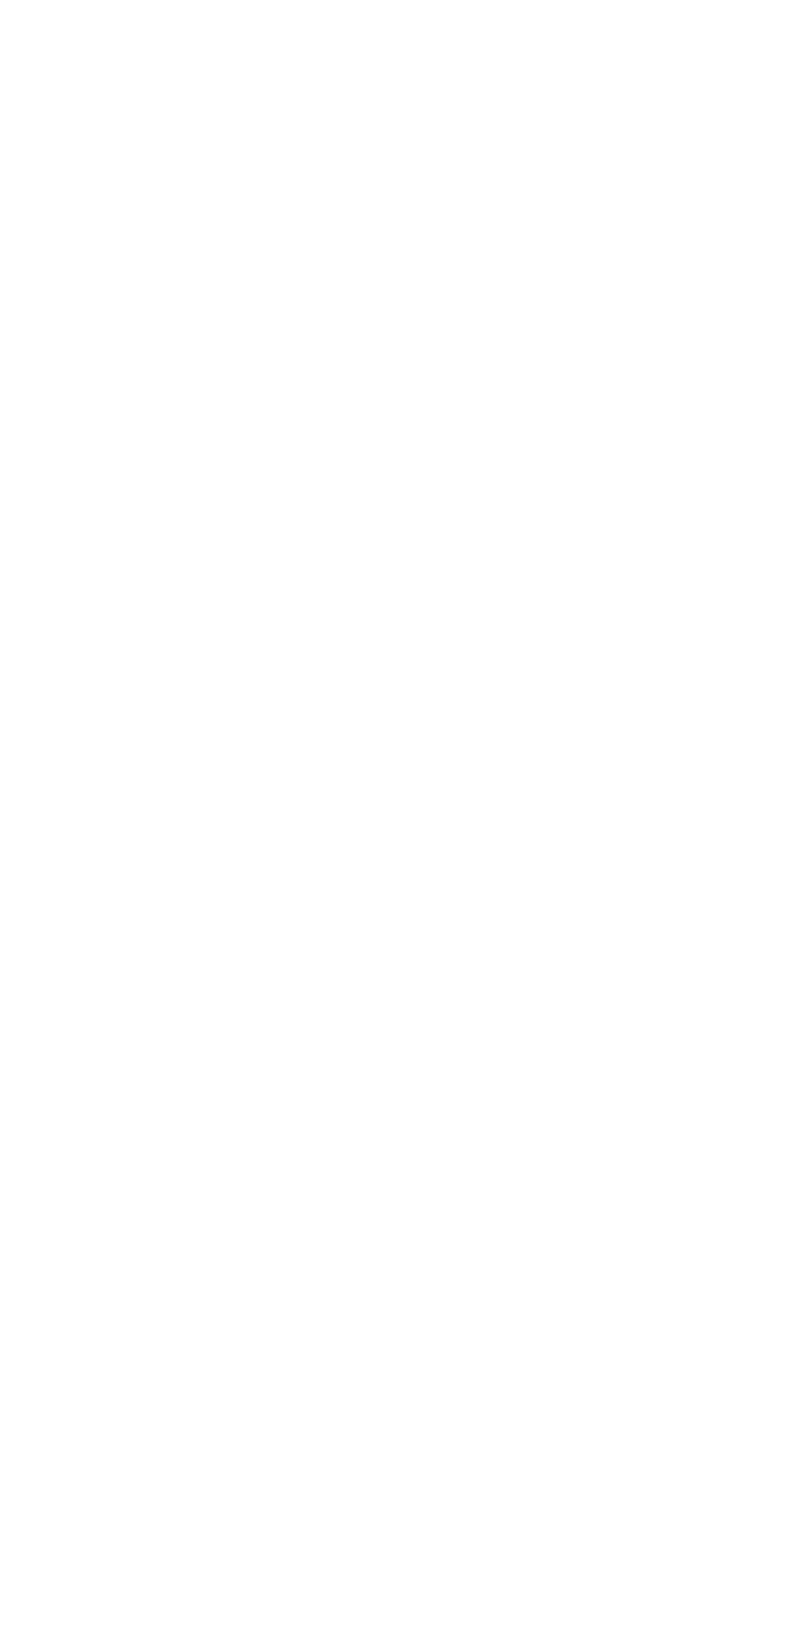

In [33]:
# AutoViz for EDA, run on a subset of the columns, too many columns will take too long, and may not be useful.
AV = AutoViz_Class()

autoviz_report = AV.AutoViz(df_eda_subset, depVar='is_fraud', verbose=0)

'''autoviz_report = AV.AutoViz(
    filename=fname + '_subset.csv',
    sep=",",
    depVar="is_fraud",
    verbose=0
)'''

autoviz_report

**🧼 Autoviz Data Quality Summary**

Below is a summary of key observations for each column regarding data type, missing values, uniqueness, value range, and potential data quality (DQ) issues.

---

**✅ No Issues Found**
- `gender`, `acct_num`, `trans_date`, `unix_time`, `region`, `trans_day_of_week`, `is_weekend`, `trans_time_segment`, `area_cat`, `distance`

---

**📈 Numeric Columns with Outliers**
- `city_pop`: 24,562 outliers beyond acceptable range. Consider capping or removal.
- `amt`: 8,453 outliers above 178.56 or below -93.92. Capping or removal advised.
- `trans_hour`: 4,009 outliers above 29 or below 5.
- `age`: 945 outliers above 90.5 or below -9.5.
- `time_since_last_trans`: 10,681 outliers above 1261.90 or below -632.74.

---

**🧠 Categorical Columns with Rare Values**
- `category`: 6 rare categories (e.g., `shopping_net`, `gas_transport`). Group or drop them.
- `age_group`: 1 rare category: `child`.
- `cc_type`: 1 rare category: `Switch`.
- `job_cat`: 1 rare category: `Architecture`.

---

**⚠️ High Cardinality or Complexity**
- `job`: 639 unique values. Consider **hash encoding** or **text embedding**.
- `dob`, `trans_time`: Date/time columns that need transformation before modeling.

---

**🎯 Target Column**
- `is_fraud`: Binary class label. Classes appear **imbalanced** — consider resampling strategies for modeling.

---

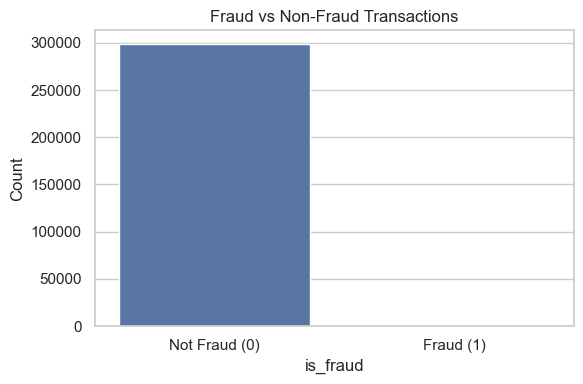

is_fraud
0    99.475326
1     0.524674
Name: proportion, dtype: float64
         city_pop      acct_num         amt         distance     \
count  2.999960e+05  2.999960e+05  299996.000000  299996.000000   
mean   2.963910e+05  4.979541e+11      66.666112      76.509002   
std    5.705556e+05  2.893002e+11     204.176166      29.203572   
min    4.400000e+01  1.837412e+07       1.000000       0.061514   
25%    1.771500e+04  2.469957e+11       8.230000      55.620571   
50%    6.079700e+04  4.975043e+11      33.150000      78.718629   
75%    2.368230e+05  7.507955e+11      76.392500      98.924832   
max    2.906700e+06  9.999583e+11   24006.930000     148.455852   

       time_since_last_trans  
count      299996.000000      
mean          427.354072      
std           560.720134      
min             0.000000      
25%            77.872153      
50%           239.562222      
75%           551.475208      
max          7923.052500      


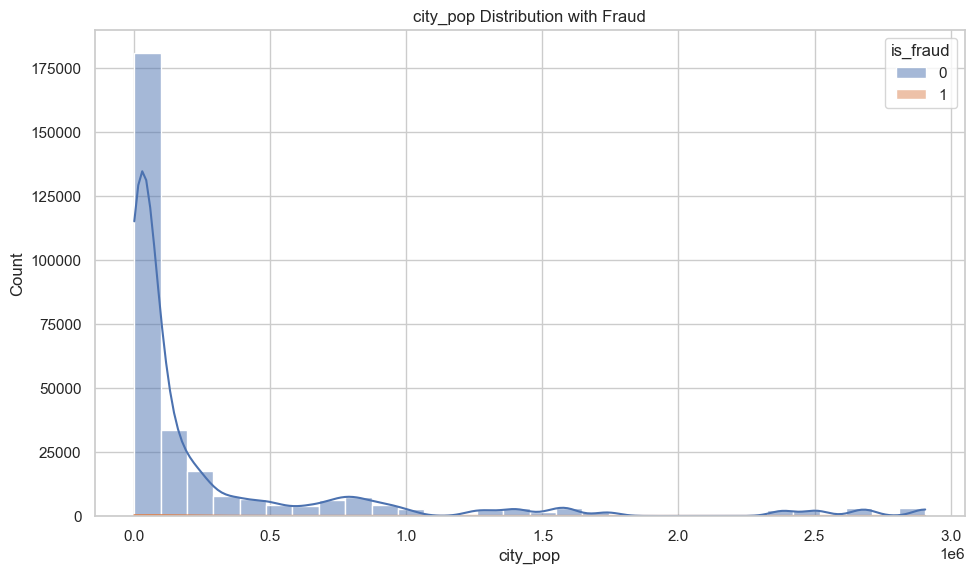

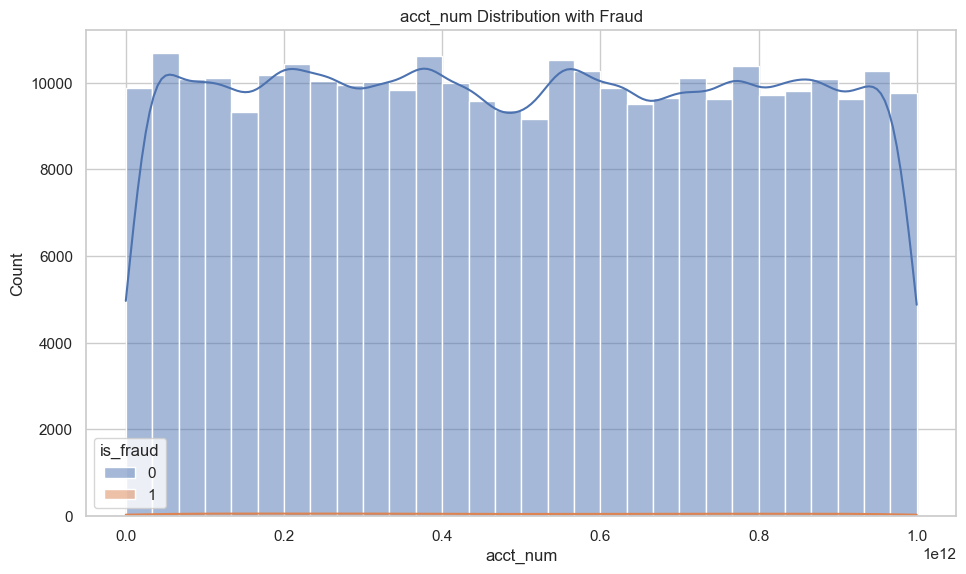

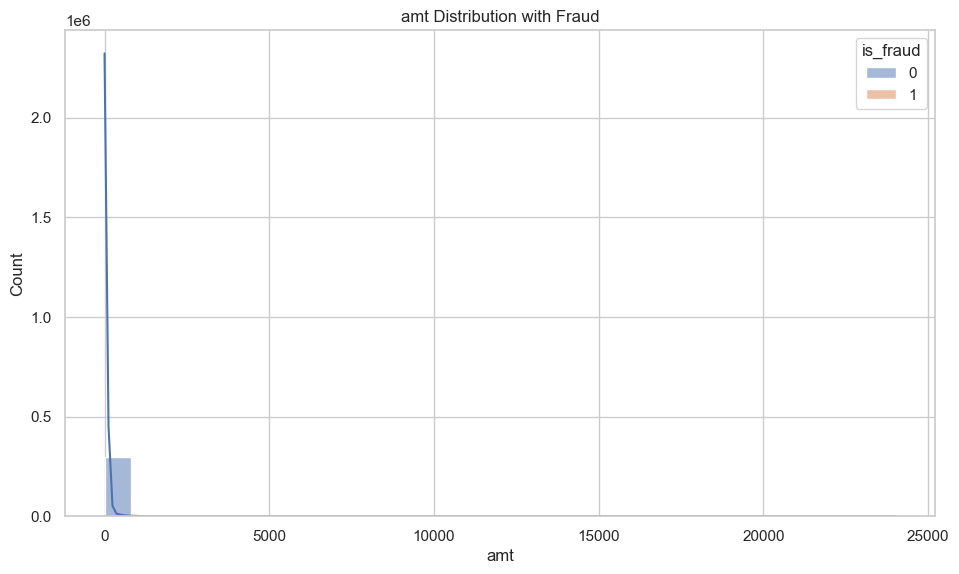

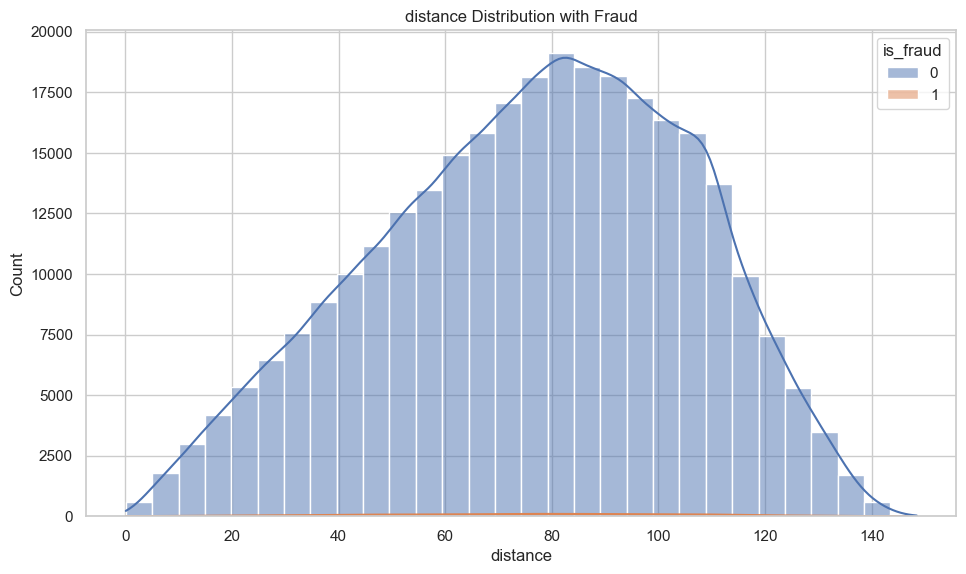

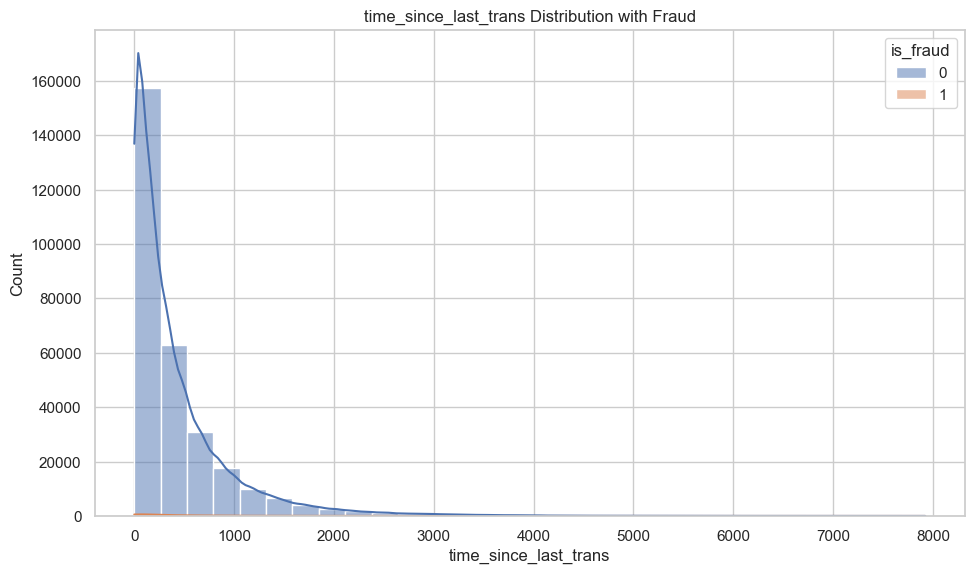

In [34]:
# Set plot style
sns.set(style="whitegrid")

df_tmp = df_eda_subset[cols_of_interest]

# Distribution of the target variable
fraud_counts = df_tmp['is_fraud'].value_counts(normalize=True) * 100

# Basic statistics for numeric features
numeric_df = df_tmp.select_dtypes(include=['int64', 'float64'])
#desc_stats = 



# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df_tmp)
plt.title('Fraud vs Non-Fraud Transactions')
plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
plt.ylabel('Count')
plt.xlabel('is_fraud')
plt.tight_layout()
plt.show()

print(fraud_counts)
print(numeric_df.describe())

for col in numeric_df.columns:
    plot_numerical(df_tmp, col)

**Categorical Features EDA**

In [35]:
df_eda_subset.head()   

gender  city_pop       job          dob      acct_num trans_date  \
70705    f      7765    energy_manager 1941-05-26  18374117 2020-02-10   
69722    f      7765    energy_manager 1941-05-26  18374117 2020-02-14   
69411    f      7765    energy_manager 1941-05-26  18374117 2020-04-04   
70857    f      7765    energy_manager 1941-05-26  18374117 2020-04-30   
69729    f      7765    energy_manager 1941-05-26  18374117 2020-05-07   

           trans_time       unix_time     category      amt   is_fraud  \
70705 1900-01-01 22:53:18  1581355398     grocery_pos   8.40      1      
69722 1900-01-01 03:44:34  1581632074   entertainment   5.10      0      
69411 1900-01-01 02:16:05  1585946765     food_dining  93.69      0      
70857 1900-01-01 16:30:21  1588244421  health_fitness  78.05      0      
69729 1900-01-01 19:26:17  1588859777  health_fitness  12.46      0      

       region   trans_day_of_week  is_weekend  trans_hour trans_time_segment  \
70705  Midwest          0               0          22         evening_18-24    
69722  Midwest          4               0           3        late_night_0-6    
69411  Midwest          5               1           2        late_night_0-6    
70857  Midwest          3               0          16       afternoon_12-18    
69729  Midwest          3               0          19         evening_18-24    

       age age_group cc_type  area_cat   distance   time_since_last_trans  \
70705  79    senior   Unknown   urban    92.807059          0.000000        
69722  79    senior   Unknown   urban   111.944237         76.854444        
69411  79    senior   Unknown   urban    98.159778       1198.525278        
70857  79    senior   Unknown   urban    41.599238        638.237778        
69729  79    senior   Unknown   urban    83.879382        170.932222        

        job_cat    
70705  Management  
69722  Management  
69411  Management  
70857  Management  
69729  Management

In [36]:
df_eda_subset.columns

Index(['gender', 'city_pop', 'job', 'dob', 'acct_num', 'trans_date',
       'trans_time', 'unix_time', 'category', 'amt', 'is_fraud', 'region',
       'trans_day_of_week', 'is_weekend', 'trans_hour', 'trans_time_segment',
       'age', 'age_group', 'cc_type', 'area_cat', 'distance',
       'time_since_last_trans', 'job_cat'],
      dtype='object')

In [37]:

# Select categorical features to test
cat_features = ['category', 'region', 'job_cat', 'cc_type', 'area_cat', 'trans_time_segment', 'age_group']
#add gender
#remove 'state'
#df_cat = df_eda[cat_features]

# Chi-square test results
chi2_results = []

for col in cat_features:
    contingency_table = pd.crosstab(df_eda[col], df_eda['is_fraud'])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    chi2_results.append((col, p))

# pack chi results in DataFrame
chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'p_value']).sort_values(by='p_value')

# Plotting bar plots of top 4 significant categorical features
top_cats = chi2_df.head(8)['Feature'].tolist()

top_cats



['category',
 'trans_time_segment',
 'age_group',
 'area_cat',
 'cc_type',
 'job_cat',
 'region']

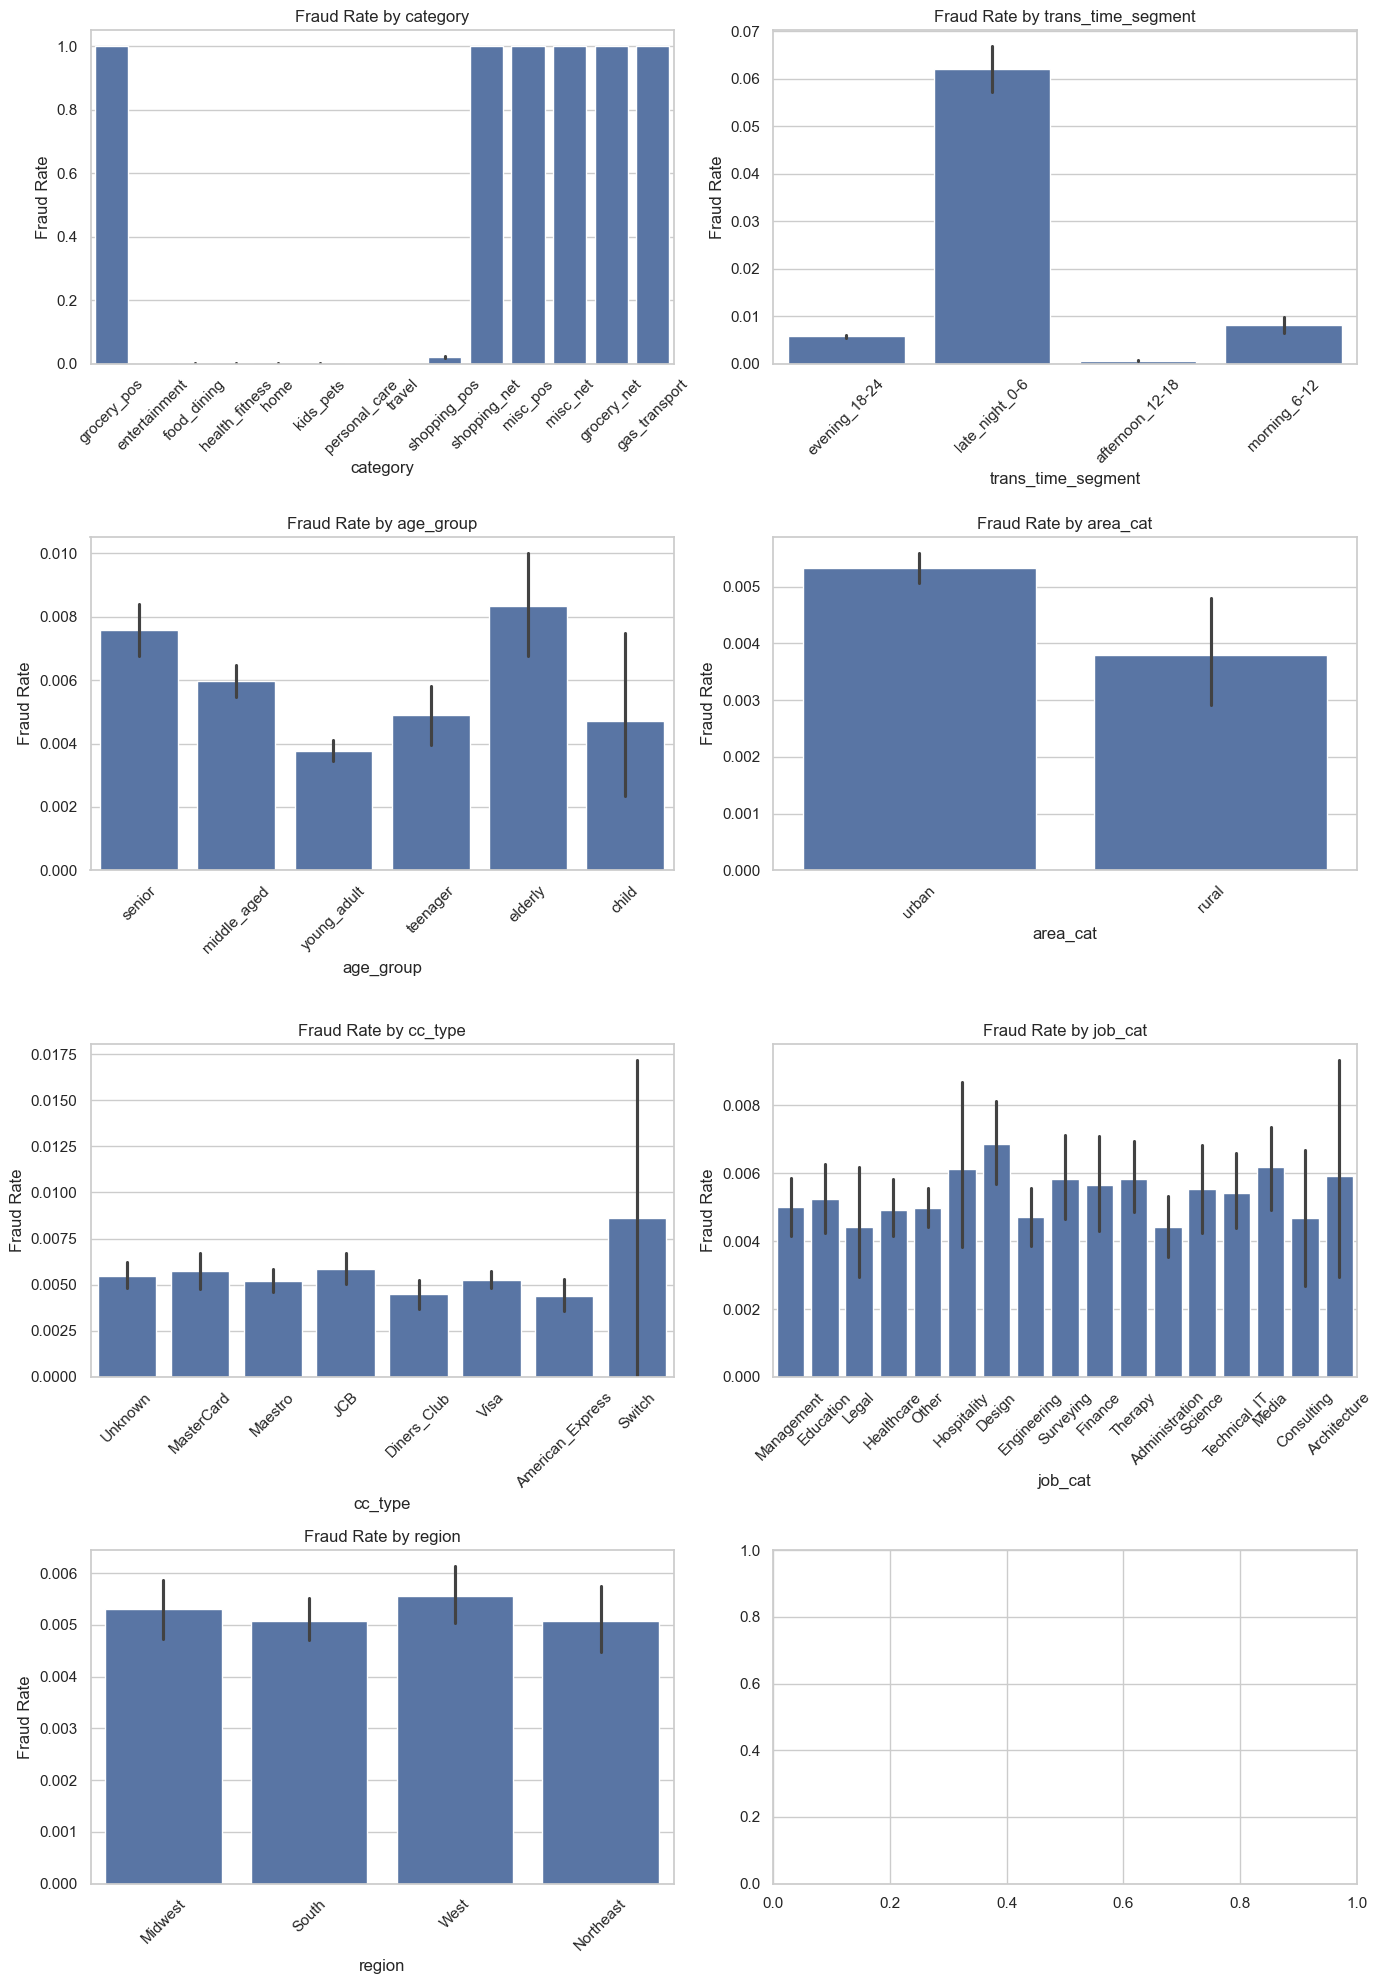

Feature           p_value  
0            category  0.000000e+00
5  trans_time_segment  0.000000e+00
6           age_group  6.897471e-26
4            area_cat  1.108955e-02
3             cc_type  1.321970e-01
2             job_cat  1.930610e-01
1              region  5.248229e-01

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(14, 20))
for i, col in enumerate(top_cats):
    ax = axes[i//2, i%2]
    sns.barplot(x=col, y='is_fraud', data=df_eda, ax=ax, estimator=lambda x: sum(x)/len(x))
    ax.set_title(f'Fraud Rate by {col}')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

chi2_df

**📊 Chi-Square Test Results Summary**

The Chi-Square test was used to assess the relationship between **categorical features** and the target variable (`is_fraud`). Here's a breakdown of the features based on their **p-values**:

---

**✅ Statistically Significant Features**  
These features have **p-values < 0.05**, suggesting a significant association with fraud:

| Feature             | p-value         | Insight |
|---------------------|------------------|---------|
| `category`          | 0.000000e+00     | Strongest predictor of fraud. |
| `trans_time_segment`| 0.000000e+00     | Time-of-day significantly linked to fraud likelihood. |
| `age_group`         | 6.90e-26         | Age category is highly informative. |
| `area_cat`          | 1.11e-02         | Slight but significant link to fraud. |

---

**⚠️ Not Statistically Significant (p ≥ 0.05)**  
These features show **no strong evidence** of association with fraud:

| Feature     | p-value     |
|-------------|-------------|
| `cc_type`   | 0.132       |
| `job_cat`   | 0.193       |
| `region`    | 0.525       |

🔹 These may still be useful in interactions or non-linear models, but not as standalone predictors.

---

**🧠 Conclusion**  
Focus on the top features (`category`, `trans_time_segment`, `age_group`) for modeling and feature engineering. Lower-ranked features may be candidates for dimensionality reduction or elimination based on further analysis.

**Numerical Features EDA**

In [39]:
df_eda_subset.columns

Index(['gender', 'city_pop', 'job', 'dob', 'acct_num', 'trans_date',
       'trans_time', 'unix_time', 'category', 'amt', 'is_fraud', 'region',
       'trans_day_of_week', 'is_weekend', 'trans_hour', 'trans_time_segment',
       'age', 'age_group', 'cc_type', 'area_cat', 'distance',
       'time_since_last_trans', 'job_cat'],
      dtype='object')

In [40]:


# Filter fraud vs non-fraud subsets
is_fraud = df_eda[df_eda['is_fraud'] == 1]
not_fraud = df_eda[df_eda['is_fraud'] == 0]

# Numerical columns to test (excluding identifiers)
numerical_cols = [
    'amt', 'distance', 'time_since_last_trans', 'city_pop', 'trans_hour', 'age'
]

# Run t-tests and skewness
t_test_results = []
skewness = []

for col in numerical_cols:
    t_stat, p_val = ttest_ind(is_fraud[col], not_fraud[col], equal_var=False)
    t_test_results.append((col, p_val))
    skew_val = skew(df_eda[col])
    skewness.append((col, skew_val))

# Convert to DataFrames
ttest_df = pd.DataFrame(t_test_results, columns=['Feature', 'p_value']).sort_values(by='p_value')
skew_df = pd.DataFrame(skewness, columns=['Feature', 'Skewness']).sort_values(by='Skewness', ascending=False)

print(ttest_df)
print(skew_df)


         Feature             p_value   
0                    amt  1.474477e-291
4             trans_hour   9.643949e-41
5                    age   2.617286e-24
1               distance   2.606186e-01
2  time_since_last_trans   2.950272e-01
3               city_pop   5.266713e-01
         Feature          Skewness 
0                    amt  36.444861
2  time_since_last_trans   3.159048
3               city_pop   2.909727
5                    age   0.694455
1               distance  -0.242706
4             trans_hour  -0.987469


**📊 T-Test & Skewness Analysis Summary**

Statistical tests were applied to assess the relationship of **numeric features** with fraud labels (`is_fraud`) and to examine distribution characteristics via skewness.

---

**✅ T-Test Results (Significance of Mean Differences)**

The T-test evaluates whether the **mean of each feature** differs significantly between fraud and non-fraud transactions.

| Feature               | p-value         | Insight |
|-----------------------|------------------|---------|
| `amt`                 | 1.47e-291        | 🚨 Extremely strong difference — high fraud relevance. |
| `trans_hour`          | 9.64e-41         | Strong significance — time of day matters. |
| `age`                 | 2.62e-24         | Significant relationship with fraud. |
| `distance`            | 0.260            | ❌ Not statistically significant. |
| `time_since_last_trans` | 0.295          | ❌ Not significant. |
| `city_pop`            | 0.527            | ❌ No significant difference between fraud and non-fraud. |

> ✅ Features with **p < 0.05** are considered **significantly associated with fraud**.

---

**📈 Skewness Results (Distribution Shape)**

Skewness measures the asymmetry of feature distributions. High positive or negative values suggest **non-normality**, which can affect model performance.

| Feature                | Skewness     | Distribution |
|------------------------|--------------|--------------|
| `amt`                 | 36.44        | 🚨 Highly right-skewed (extreme outliers present) |
| `time_since_last_trans` | 3.16       | Strong right-skew |
| `city_pop`            | 2.91         | Right-skewed |
| `age`                 | 0.69         | Mild right-skew |
| `distance`            | -0.24        | Slight left-skew |
| `trans_hour`          | -0.99        | Moderate left-skew |

> ⚠️ Features with high skewness may benefit from **log transformations or normalization** during preprocessing.

---

**🧠 Conclusion**

- Focus modeling efforts on `amt`, `trans_hour`, and `age` — all are statistically significant and relevant.
- Apply transformations (e.g., `log1p`) to handle **highly skewed features** like `amt`, `city_pop`, and `time_since_last_trans`.
- Features like `distance`, `city_pop`, and `time_since_last_trans` are **not strongly linked** to fraud based on mean difference tests, though they may help in interactions.


**Study features with high skewness**

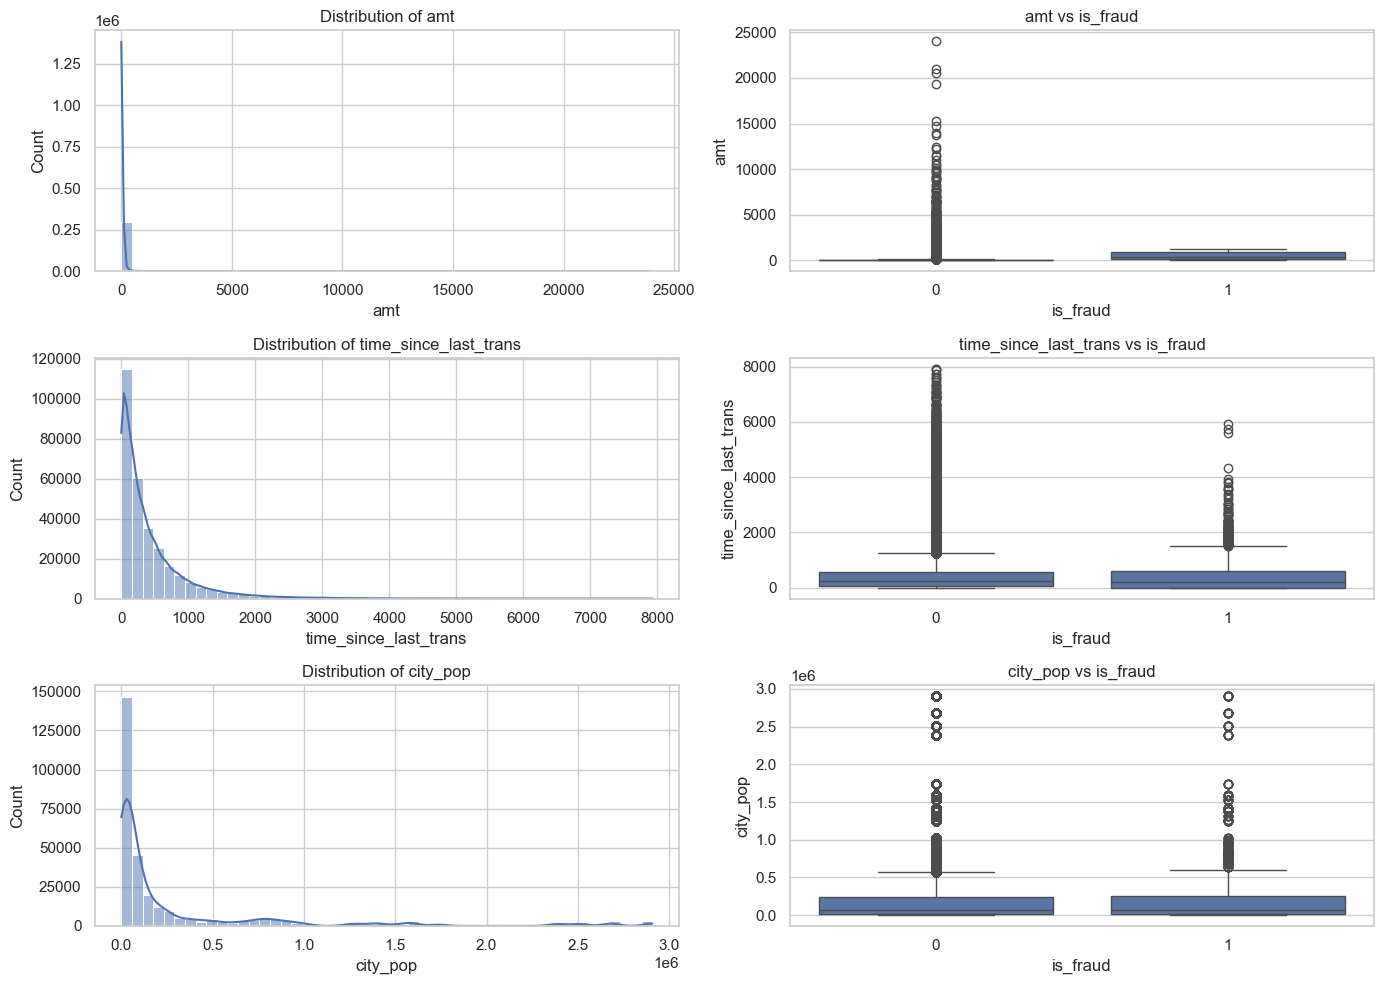

In [41]:
# Features with high skewness
skewed_features = ['amt', 'time_since_last_trans', 'city_pop']

# Plot distributions and boxplots
fig, axes = plt.subplots(len(skewed_features), 2, figsize=(14, 10))

for i, feature in enumerate(skewed_features):
    # Distribution plot
    sns.histplot(df_eda[feature], kde=True, ax=axes[i][0], bins=50)
    axes[i][0].set_title(f'Distribution of {feature}')
    
    # Boxplot by fraud status
    sns.boxplot(x='is_fraud', y=feature, data=df_eda, ax=axes[i][1])
    axes[i][1].set_title(f'{feature} vs is_fraud')

plt.tight_layout()
plt.show()

**💡 Insights from Skewness & Outlier Visualization**

---

**🔸 amt**
- Highly **right-skewed**, with a long tail of high-value transactions.
- Fraudulent transactions tend to involve **larger amounts**.
- ✅ Log transformation is recommended to reduce skew and normalize the distribution.

---

**🔸 time_since_last_trans**
- **Right-skewed** with many zeros and a long tail.
- Fraud transactions aren't concentrated in one region.
- ⚠️ Likely **not predictive on its own**, but may add value in **interaction features**.

---

**🔸 city_pop**
- Skewed toward **smaller population** regions.
- 📊 Boxplot shows **no visible difference** between fraud and non-fraud.

**Action Items:
*   Handle Imbalance: Oversampling (SMOTE) or undersampling required before modeling.
*   Transform skewed features: Apply log1p() to *amt*, *city_pop*, and *time_since_last_trans*.
*   Consider Feature Engineering:
    *   Combine *trans_hour* with *is_weekend* or *category* for patterns.
    *   Create bins for *amt* or *distance* to simplify modeling.


**Apply log transformation on skewed features**

In [46]:
skewed_cols = ['amt', 'time_since_last_trans', 'city_pop']
for col in skewed_cols:
    df_eda_subset[f'log_{col}'] = np.log1p(df_eda_subset[col]) # log transform the column to reduce skewness and normalize the distribution
    df_eda[f'log_{col}'] = np.log1p(df_eda[col]) # update the original dataframe as well, skip the merge later

In [47]:
df_eda.head()

cc_num      gender   city  state   zip     lat     long    \
70705  3510694985435665    f    sidney   NE   69162  41.138 -102.9856   
69722  3510694985435665    f    sidney   NE   69162  41.138 -102.9856   
69411  3510694985435665    f    sidney   NE   69162  41.138 -102.9856   
70857  3510694985435665    f    sidney   NE   69162  41.138 -102.9856   
69729  3510694985435665    f    sidney   NE   69162  41.138 -102.9856   

       city_pop       job          dob      acct_num  \
70705    7765    energy_manager 1941-05-26  18374117   
69722    7765    energy_manager 1941-05-26  18374117   
69411    7765    energy_manager 1941-05-26  18374117   
70857    7765    energy_manager 1941-05-26  18374117   
69729    7765    energy_manager 1941-05-26  18374117   

                 profile                         trans_num              \
70705  adults_50up_female_urban.json  d0128ff7fe0a531c0e5ae54b90165a4f   
69722  adults_50up_female_urban.json  8bb14d2b30f22502d2d5e28aa7f78c2b   
69411  adults_50up_female_urban.json  0ee22c7da388b0e7f99c9cb02daeba9d   
70857  adults_50up_female_urban.json  cdc7e42669891ca8fb13480b97db9986   
69729  adults_50up_female_urban.json  a10ce6820b85d78580b0d2c41fcc8bf2   

      trans_date      trans_time       unix_time     category      amt   \
70705 2020-02-10 1900-01-01 22:53:18  1581355398     grocery_pos   8.40   
69722 2020-02-14 1900-01-01 03:44:34  1581632074   entertainment   5.10   
69411 2020-04-04 1900-01-01 02:16:05  1585946765     food_dining  93.69   
70857 2020-04-30 1900-01-01 16:30:21  1588244421  health_fitness  78.05   
69729 2020-05-07 1900-01-01 19:26:17  1588859777  health_fitness  12.46   

       is_fraud              merchant               merch_lat  merch_long  \
70705      1                        fraud_cole_plc  41.732479 -102.205221   
69722      0                       fraud_upton_plc  41.907672 -103.851581   
69411      0                    fraud_conroy-emard  40.524424 -102.147902   
70857      0     fraud_turcotte_batz_and_buckridge  41.186713 -102.494157   
69729      0                      fraud_jacobi_inc  41.660959 -102.261912   

       region   trans_day_of_week  is_weekend  trans_hour trans_time_segment  \
70705  Midwest          0               0          22         evening_18-24    
69722  Midwest          4               0           3        late_night_0-6    
69411  Midwest          5               1           2        late_night_0-6    
70857  Midwest          3               0          16       afternoon_12-18    
69729  Midwest          3               0          19         evening_18-24    

       age age_group cc_type  area_cat   distance   time_since_last_trans  \
70705  79    senior   Unknown   urban    92.807059          0.000000        
69722  79    senior   Unknown   urban   111.944237         76.854444        
69411  79    senior   Unknown   urban    98.159778       1198.525278        
70857  79    senior   Unknown   urban    41.599238        638.237778        
69729  79    senior   Unknown   urban    83.879382        170.932222        

        job_cat     log_amt  log_time_since_last_trans  log_city_pop  
70705  Management  2.240710          0.000000             8.957511    
69722  Management  1.808289          4.354841             8.957511    
69411  Management  4.550608          7.089681             8.957511    
70857  Management  4.370081          6.460276             8.957511    
69729  Management  2.599722          5.147100             8.957511

**Show correlation between is_fraud and numerical features**

corr() uses Pearson correlation by default

In [48]:
df_eda_subset['is_fraud'] = df_eda['is_fraud'].astype('int64')

In [49]:
df_corr = df_eda_subset.select_dtypes(include=['int64', 'float64', 'int']).corr()
#sort absolute values to include negative correlations
target_corr = df_corr['is_fraud'].sort_values(ascending=False)


print(target_corr)

is_fraud                     1.000000
amt                          0.160389
log_amt                      0.118029
age                          0.020321
log_city_pop                 0.003444
time_since_last_trans        0.002267
city_pop                     0.001159
acct_num                    -0.000973
distance                    -0.002036
is_weekend                  -0.012119
unix_time                   -0.015002
trans_day_of_week           -0.015360
log_time_since_last_trans   -0.030141
trans_hour                  -0.054274
Name: is_fraud, dtype: float64


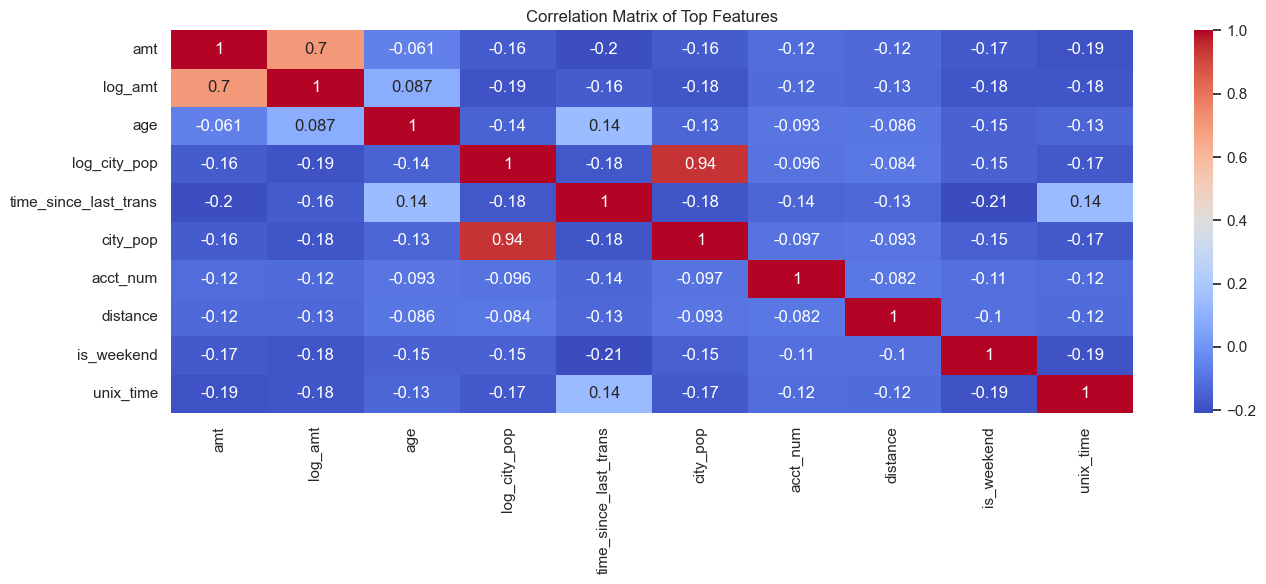

is_fraud                 1.000000
amt                      0.160389
log_amt                  0.118029
age                      0.020321
log_city_pop             0.003444
time_since_last_trans    0.002267
city_pop                 0.001159
acct_num                -0.000973
distance                -0.002036
is_weekend              -0.012119
Name: is_fraud, dtype: float64

In [50]:
# Plot heatmap of top correlated numerical features with is_fraud
top_corr_features = target_corr[1:11].index  # Skip is_fraud itself
plt.figure(figsize=(14, 6))
sns.heatmap(df_corr[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Top Features")
plt.tight_layout()
plt.show()

target_corr.head(10)

**📈 Correlation Analysis with `is_fraud`**

The table below summarizes the **Pearson correlation coefficients** between selected numerical features and the target variable `is_fraud`.

---

**🔍 Key Positive Correlations**

| Feature     | Correlation | Insight |
|-------------|-------------|---------|
| `amt`       | **+0.160**  | Most positively correlated feature — higher amounts are linked to fraud. |
| `log_amt`   | +0.118      | Log-transformed amount still shows meaningful correlation with fraud. |
| `age`       | +0.020      | Very weak positive correlation — possibly useful in interaction terms. |

---

**🔍 Key Negative Correlations**

| Feature                     | Correlation | Insight |
|-----------------------------|-------------|---------|
| `trans_hour`                | **−0.054**  | Slight tendency for fraud to occur at specific times of day. |
| `log_time_since_last_trans`| −0.030      | Minor inverse relationship — shorter gaps may slightly reduce fraud likelihood. |
| `trans_day_of_week`        | −0.015      | Very weak — likely not predictive on its own. |
| `unix_time`                | −0.015      | Timestamp itself is not informative in raw form. |
| `is_weekend`               | −0.012      | Small negative trend — fraud may occur more on weekdays. |

---

**🧠 Neutral / Weak Predictors**

- Features like `city_pop`, `acct_num`, `distance`, and `log_city_pop` show **near-zero correlation**, suggesting little to no direct linear relationship with fraud.

---

**✅ Conclusion**

- Focus on `amt`, `log_amt`, and possibly `trans_hour` in early feature selection.
- Consider engineering **non-linear or interaction features** from weakly correlated variables.
- Correlation is only one aspect — low correlation does not mean a feature is useless, especially in non-linear models.



**Feature Importance**

using ramdom forest

In [51]:
df_eda.columns

Index(['cc_num', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'acct_num', 'profile', 'trans_num', 'trans_date',
       'trans_time', 'unix_time', 'category', 'amt', 'is_fraud', 'merchant',
       'merch_lat', 'merch_long', 'region', 'trans_day_of_week', 'is_weekend',
       'trans_hour', 'trans_time_segment', 'age', 'age_group', 'cc_type',
       'area_cat', 'distance', 'time_since_last_trans', 'job_cat', 'log_amt',
       'log_time_since_last_trans', 'log_city_pop'],
      dtype='object')

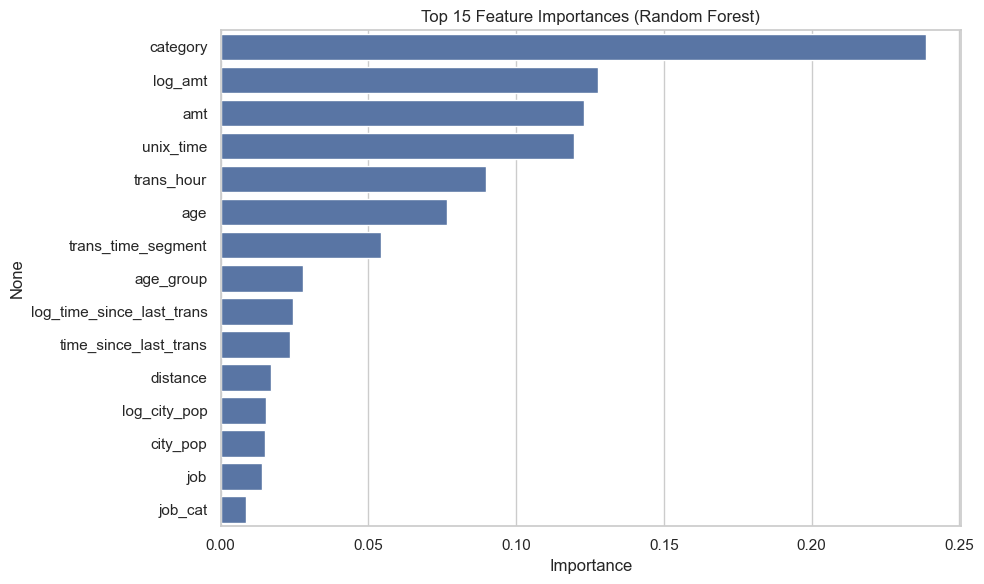

category                     0.238646
log_amt                      0.127613
amt                          0.122935
unix_time                    0.119496
trans_hour                   0.089957
age                          0.076614
trans_time_segment           0.054152
age_group                    0.027776
log_time_since_last_trans    0.024387
time_since_last_trans        0.023399
distance                     0.017157
log_city_pop                 0.015383
city_pop                     0.015181
job                          0.013929
job_cat                      0.008676
dtype: float64

In [52]:
 
df_model = df_eda_subset.copy()

# Encode categorical variables
categorical_cols = df_model.select_dtypes(include='object').columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

# Define features and target
X = df_model.drop(columns=['is_fraud', 'acct_num', 'trans_date', 'trans_time', 'dob'])
y = df_model['is_fraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train a random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 15 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[:15], y=importances.index[:15])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

importances.head(15)

**EDA Summary**
*   Target feature *'is_fraud'* is highly imbalanced, approx. 0.29% fraud.
*   Highest predictors of fraud are *'category'*, *'amt'*, *'trans_hour'*, *'age'*, *'unix_time'*.

**Recommanded Action Items:**
*   Address imbalance (e.g. SMOTE).
*   Log-transform skewed features (amt, time_since_last_trans, city_pop).
*   Use encoding & tree-based models for categorical power.
*   Consider feature interactions (e.g., time × category). 

**Save EDA data to pickle for use in later stages**


In [54]:
print(df_eda.info())
print(df_eda.head())
df_eda.to_pickle(fname + '_eda.pkl')

<class 'pandas.core.frame.DataFrame'>
Index: 299996 entries, 70705 to 127819
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   cc_num                     299996 non-null  int64         
 1   gender                     299996 non-null  object        
 2   city                       299996 non-null  object        
 3   state                      299996 non-null  object        
 4   zip                        299996 non-null  int32         
 5   lat                        299996 non-null  float64       
 6   long                       299996 non-null  float64       
 7   city_pop                   299996 non-null  int64         
 8   job                        299996 non-null  object        
 9   dob                        299996 non-null  datetime64[ns]
 10  acct_num                   299996 non-null  int64         
 11  profile                    299996 non-null  object   